<a id='home'></a>
### purpose

estimate variation in LA within each sim


### outline
1. [calculate per-population levels of local adaptation](#la)
    1. [home-away](#ha)
    1. [local-foreign](#lf)
    1. [calc LA stats across pops per seed (varLA, stdLA, coeffLA)](#varla)
1. [figures for drivers of var(LA)](#figs)
    1. [degree LA vs var(LA)](#deg_v_var)
    1. [boxplots of factors influencing var(LA)](#boxplots)
1. [anova model of factors influencing var(LA)](#anova)
    - these showed the same as boxplot figs
1. [figures for performance vs var(LA)](#perf)

In [1]:
from pythonimports import *
from myfigs import histo_box, save_pdf

import MVP_summary_functions as mvp
import MVP_00_start_pipeline as mvp00
import MVP_06_validate_RONA as mvp06

import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
plt.rcParams.update({'font.family' : 'serif'})

t0 = dt.now()  # notebook timer

lview, dview = get_client(cluster_id='1703181822-i0ck', profile='lotterhos')

summarydir = '/work/lotterhos/MVP-Offsets/run_20220919/summaries'
figdir = makedir(op.join(summarydir, 'figs/00_estimate_var_LA'))


mvp.latest_commit()
session_info.show()

36 36
#########################################################
Today:	December 21, 2023 - 13:04:07 EST
python version: 3.8.5
conda env: mvp_env

Current commit of pythonimports:
commit 419895d157c97717f835390196c13cf973d25eba  
Merge: e20434f 1e09b6c  
Author: Brandon Lind <lind.brandon.m@gmail.com>

Current commit of MVP_offsets:
commit c5bc403582e5bafc1036be8cd2a4bb0b4d154623  
Author: Brandon Lind <lind.brandon.m@gmail.com>  
Date:   Mon Dec 18 14:38:19 2023 -0500
#########################################################



<a id='la'></a>
# calc per-pop local adaptation

[top](#home)

In [2]:
# from 02_analysis/05_multivariate_sims/01_estimate_fitness_and_LA.ipynb
def get_pop_LA(transplants):
    """Calculate home-away or local-foreign fitness sensu Eqn 1 in Blanquart et al. 2013 Ecol Lett.
    
    If applied with axis=0 then home - away fitness is returned. Else if axis=1, local-foreign fitness
        is returned.
    
    Notes
    -----
    - the "1 - P" in the published equations is handled by excluding home_fitness from mean away_fitness
    - MVP fitness matrices are set up so values are the fitness of the column ID transplanted into
        the row ID
    - fitness dataframe is an n_deme x n_deme matrix with entries for deme fitness of source deme 
        (columns) in transplant deme (rows)
    
    Parameters
    ----------
    transplants : pd.Series
        if function is applied with axis=0: a column from the fitness dataframe, name=popID, 
            keys=transplant location, vals=fitness of `popID` in transplant locations
        if function is applied with axis=1: a row from the fitness dataframe, name=transplant location,
            keys=popIDs, vals=fitness of `popID`s in transplant location
            
    """
    import numpy as np

    # transplants.name is colum ID from fitness dataframe (ie pop ID)
    home_fitness = transplants.loc[transplants.name]
    away_fitness = np.mean([fitness for pop, fitness in transplants.items() if pop != transplants.name])

    return home_fitness - away_fitness

dview['get_pop_LA'] = get_pop_LA

In [3]:
def get_per_pop_LA(seed, home_away=True):
    import pandas as pd
    import MVP_summary_functions as mvp
    import MVP_06_validate_RONA as mvp06

    # fitness is an n_deme x n_deme table that indicates the mean fitness of individuals 
        # from the source deme (in columns) in the transplant deme (in rows) 
    fitness = mvp06.load_pooled_fitness_matrix(mvp.slimdir, seed)

    fitness.columns = fitness.columns.astype(str)
    fitness.index = fitness.index.astype(str)

    if home_away is True:
        per_pop_LA = fitness.apply(get_pop_LA, axis=0)
    else:  # local-foreign LA
        per_pop_LA = fitness.apply(get_pop_LA, axis=1)

    return per_pop_LA

<a id='ha'></a>
### calc  home-away LA for each pop in each seed

[top](#home)

In [4]:
seeds = mvp00.get_seeds(mvp.slimdir)

len(seeds)  # 225 seeds * 10 reps

2250

In [5]:
# calc per pop home-away fitness in parallel
jobs = []
for seed in seeds:
    jobs.append(
        lview.apply_async(
            get_per_pop_LA, **dict(seed=seed, home_away=True)
        )
    )
    
watch_async(jobs)


Watching 2250 jobs ...


100%|███████████████| 2250/2250 [00:25<00:00, 88.65it/s] 


In [6]:
# retrieve parallel jobs
pop_LA = defaultdict(dict)
for seed, j in zip(seeds, jobs):
    pop_LA['home-away'][seed] = j.r

In [7]:
# combine pop-level home-away LA into a figure
home_away_la_df = pd.DataFrame(pop_LA['home-away']).T

home_away_la_df

1         2         3         4         5         6         7  \
1231094  0.670733  0.646905  0.669739  0.649250  0.643735  0.655245  0.632993   
1231095  0.656732  0.686114  0.687303  0.672272  0.663219  0.666871  0.611360   
1231096  0.615912  0.621110  0.626478  0.629623  0.625628  0.633429  0.621818   
1231097  0.636040  0.611810  0.639919  0.622352  0.618658  0.605645  0.625232   
1231098  0.620525  0.623390  0.614807  0.630053  0.632991  0.655403  0.628759   
...           ...       ...       ...       ...       ...       ...       ...   
1233339  0.201890  0.302877  0.275989  0.252099  0.382505  0.383477  0.318642   
1233340  0.453318  0.313450  0.306338  0.396286  0.553971  0.572114  0.406975   
1233341  0.536871  0.370943  0.236649  0.362055  0.567707  0.609547  0.405525   
1233342  0.540725  0.378965  0.313187  0.415205  0.565347  0.520275  0.414173   
1233343  0.470426  0.408282  0.334241  0.473285  0.586101  0.509083  0.453150   

                8         9        10        11        12        13        14  \
1231094  0.590359  0.615083  0.526406  0.505917  0.551525  0.522348  0.561656   
1231095  0.673245  0.605447  0.605434  0.579667  0.574654  0.583480  0.572254   
1231096  0.613821  0.630609  0.596385  0.547136  0.549917  0.538125  0.542857   
1231097  0.619179  0.631007  0.614218  0.539051  0.532271  0.544069  0.541991   
1231098  0.612643  0.617480  0.646653  0.551102  0.547696  0.561739  0.557277   
...           ...       ...       ...       ...       ...       ...       ...   
1233339  0.248548  0.401652  0.506040  0.267868  0.304536  0.292849  0.333914   
1233340  0.241872  0.270747  0.241674  0.454941  0.394020  0.303520  0.390072   
1233341  0.281288  0.370962  0.596517  0.573586  0.345194  0.273679  0.356794   
1233342  0.300957  0.375718  0.542427  0.554735  0.334069  0.323007  0.420939   
1233343  0.284093  0.353138  0.258114  0.452143  0.418286  0.336927  0.455679   

               15        16        17        18        19        20        21  \
1231094  0.536193  0.559289  0.539436  0.541522  0.509246  0.504307  0.497126   
1231095  0.589824  0.584392  0.576461  0.536331  0.537215  0.475777  0.481494   
1231096  0.543850  0.558272  0.535237  0.554138  0.554122  0.543995  0.489239   
1231097  0.553054  0.557721  0.539310  0.540874  0.538628  0.506879  0.476761   
1231098  0.538334  0.520776  0.536217  0.493979  0.513383  0.478606  0.470774   
...           ...       ...       ...       ...       ...       ...       ...   
1233339  0.445356  0.463029  0.332465  0.247107  0.314077  0.615120  0.227492   
1233340  0.458307  0.530863  0.342430  0.324327  0.261212  0.262610  0.428745   
1233341  0.583422  0.540644  0.357506  0.261500  0.373106  0.545896  0.488211   
1233342  0.491359  0.515948  0.413304  0.314842  0.302900  0.532177  0.544245   
1233343  0.500421  0.508079  0.417813  0.272186  0.378960  0.287687  0.461239   

               22        23        24        25        26        27        28  \
1231094  0.490664  0.488885  0.478090  0.475465  0.480895  0.484853  0.485389   
1231095  0.480888  0.480852  0.490171  0.489197  0.463406  0.455404  0.479455   
1231096  0.476774  0.477878  0.492533  0.477910  0.483365  0.489531  0.487821   
1231097  0.480320  0.482444  0.478066  0.462275  0.467736  0.489752  0.474634   
1231098  0.474717  0.453753  0.481784  0.454083  0.476286  0.464655  0.459720   
...           ...       ...       ...       ...       ...       ...       ...   
1233339  0.337952  0.315142  0.341412  0.492880  0.460808  0.345141  0.271614   
1233340  0.335269  0.289592  0.331457  0.415543  0.374097  0.338090  0.275598   
1233341  0.353006  0.299362  0.335926  0.523742  0.501979  0.356630  0.286637   
1233342  0.333580  0.325729  0.400087  0.467324  0.479347  0.399878  0.334710   
1233343  0.316017  0.284328  0.432428  0.540244  0.526646  0.402995  0.227424   

               29        30        31        32        33        34        35  \
1231094  0.489313  0.461021  0.450333  0.44

<a id='lf'></a>
### calc  local-foreign LA for each pop in each seed

[top](#home)

In [8]:
# calc per pop local-foreign LA in parallel
jobs = []
for seed in seeds:
    jobs.append(
        lview.apply_async(
            get_per_pop_LA, **dict(seed=seed, home_away=False)
        )
    )
    
watch_async(jobs)


Watching 2250 jobs ...


100%|███████████████| 2250/2250 [00:13<00:00, 162.85it/s]  


In [9]:
for seed, j in zip(seeds, jobs):
    pop_LA['local-foreign'][seed] = j.r

In [10]:
# combine pop-level local adaptation into a figure
local_foreign_la_df = pd.DataFrame(pop_LA['local-foreign']).T

local_foreign_la_df

1         2         3         4         5         6         7  \
1231094  0.658017  0.649082  0.647677  0.648067  0.639580  0.659807  0.637250   
1231095  0.648788  0.653479  0.666079  0.657191  0.631611  0.663516  0.630531   
1231096  0.634458  0.634086  0.635857  0.642654  0.638827  0.634386  0.633544   
1231097  0.627068  0.619266  0.634853  0.627302  0.620626  0.619347  0.631434   
1231098  0.623008  0.639583  0.613558  0.623828  0.625780  0.644268  0.637523   
...           ...       ...       ...       ...       ...       ...       ...   
1233339  0.384207  0.405302  0.340272  0.315802  0.446944  0.459738  0.367552   
1233340  0.534095  0.249922  0.197069  0.300800  0.530129  0.518445  0.354059   
1233341  0.576756  0.377341  0.275308  0.342884  0.579059  0.610467  0.376127   
1233342  0.585543  0.368910  0.337023  0.414055  0.541400  0.530661  0.409990   
1233343  0.553957  0.358002  0.273711  0.423212  0.556643  0.535751  0.397834   

                8         9        10        11        12        13        14  \
1231094  0.620574  0.647344  0.598437  0.521580  0.545369  0.535926  0.544204   
1231095  0.664390  0.647211  0.632305  0.579233  0.583983  0.565957  0.578203   
1231096  0.634470  0.638899  0.624338  0.544784  0.552616  0.549234  0.540854   
1231097  0.635478  0.629211  0.624131  0.549018  0.549176  0.550451  0.542113   
1231098  0.621272  0.634892  0.651107  0.548763  0.554743  0.559216  0.561786   
...           ...       ...       ...       ...       ...       ...       ...   
1233339  0.285044  0.327777  0.535381  0.407927  0.368217  0.319088  0.349696   
1233340  0.275569  0.316799  0.410623  0.487306  0.298641  0.309963  0.383907   
1233341  0.305820  0.398490  0.589865  0.569726  0.364013  0.296827  0.328232   
1233342  0.310235  0.364125  0.581307  0.573971  0.343392  0.331102  0.389808   
1233343  0.265026  0.374894  0.432835  0.552163  0.351790  0.254509  0.388327   

               15        16        17        18        19        20        21  \
1231094  0.544972  0.542711  0.549203  0.538571  0.530185  0.532176  0.489001   
1231095  0.581045  0.585962  0.580421  0.565318  0.559999  0.534706  0.497508   
1231096  0.545595  0.553037  0.541340  0.551553  0.545211  0.534928  0.487814   
1231097  0.546683  0.556836  0.536555  0.532547  0.533064  0.511487  0.471603   
1231098  0.543559  0.530976  0.548543  0.528385  0.525336  0.500916  0.470800   
...           ...       ...       ...       ...       ...       ...       ...   
1233339  0.480926  0.490464  0.363177  0.227497  0.241251  0.553800  0.397795   
1233340  0.506483  0.554571  0.217303  0.306627  0.289293  0.408435  0.462537   
1233341  0.568055  0.550626  0.320364  0.278056  0.417874  0.542254  0.498964   
1233342  0.492759  0.494222  0.372792  0.325937  0.281330  0.579740  0.553718   
1233343  0.509646  0.518938  0.284626  0.202513  0.376017  0.446155  0.545037   

               22        23        24        25        26        27        28  \
1231094  0.486930  0.473090  0.466929  0.467531  0.475651  0.472100  0.477484   
1231095  0.487073  0.492752  0.492426  0.495311  0.475629  0.481049  0.489315   
1231096  0.470004  0.480195  0.489594  0.479058  0.483314  0.483348  0.484491   
1231097  0.482548  0.476064  0.477410  0.462763  0.469665  0.473828  0.469392   
1231098  0.485382  0.458121  0.488498  0.454078  0.480938  0.456782  0.455232   
...           ...       ...       ...       ...       ...       ...       ...   
1233339  0.381035  0.314917  0.327598  0.502833  0.489471  0.338772  0.252013   
1233340  0.271462  0.293488  0.319670  0.469336  0.405116  0.317190  0.294385   
1233341  0.345569  0.305913  0.292935  0.505365  0.505953  0.341872  0.290379   
1233342  0.317674  0.326279  0.379102  0.470368  0.469296  0.385700  0.333562   
1233343  0.253799  0.193728  0.335842  0.523128  0.511981  0.313705  0.148980   

               29        30        31        32        33        34        35  \
1231094  0.470644  0.445749  0.431448  0.43

<AxesSubplot:>

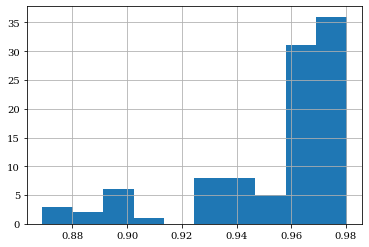

In [11]:
# correlation across seeds between H-A and L-F
local_foreign_la_df.corrwith(home_away_la_df, axis=0).hist()

<AxesSubplot:>

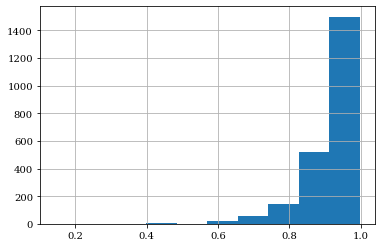

In [12]:
# correlation within seeds between H-A and L-F
local_foreign_la_df.corrwith(home_away_la_df, axis=1).hist()

<a id='varla'></a>
### calc LA stats across pops per seed (varLA, stdLA, coeffLA)

[top](#home)

In [13]:
var_LA = defaultdict(dict)  # variance in local adaptation
std_LA = defaultdict(dict)  # standard dev in local adaptation
coeff = defaultdict(dict)  # coefficient of variation in local adaptation
for la_type in ['home-away', 'local-foreign']:
    for seed, pop_la in pop_LA[la_type].items():
        var_LA[la_type][seed] = pop_la.var()
        coeff[la_type][seed] = pop_la.std() / pop_la.mean()
        std_LA[la_type][seed] = pop_la.std()

# add home-away LA
var_la_df = pd.DataFrame(var_LA['home-away'], index=['var(home-away)']).T
coeff_df = pd.DataFrame(coeff['home-away'], index=['coeff(home-away)']).T
std_la_df = pd.DataFrame(std_LA['home-away'], index=['std(home-away)']).T

# add local-foreign LA
var_la_df['var(local-foreign)'] = var_la_df.index.map(var_LA['local-foreign'])# pd.DataFrame(var_LA['local-foreign'], index=['local-foreign']).T
coeff_df['coeff(local-foreign)'] = coeff_df.index.map(coeff['local-foreign']) #pd.DataFrame(coeff['local-foreign'], index=['local-foreign']).T
std_la_df['std(local-foreign)'] = std_la_df.index.map(std_LA['local-foreign'])

var_la_df

var(home-away)  var(local-foreign)
1231094        0.006398            0.007387
1231095        0.006800            0.006984
1231096        0.005356            0.006572
1231097        0.005321            0.006183
1231098        0.006009            0.007211
...                 ...                 ...
1233339        0.008123            0.009677
1233340        0.006248            0.009655
1233341        0.007844            0.008965
1233342        0.008638            0.011132
1233343        0.009338            0.012146

[2250 rows x 2 columns]

In [14]:
coeff_df

coeff(home-away)  coeff(local-foreign)
1231094          0.159705              0.171604
1231095          0.163268              0.165466
1231096          0.146588              0.162380
1231097          0.146082              0.157458
1231098          0.154715              0.169483
...                   ...                   ...
1233339          0.238340              0.260143
1233340          0.204532              0.254247
1233341          0.217606              0.232638
1233342          0.225831              0.256377
1233343          0.266958              0.304461

[2250 rows x 2 columns]

In [15]:
std_la_df

std(home-away)  std(local-foreign)
1231094        0.079989            0.085949
1231095        0.082462            0.083572
1231096        0.073187            0.081071
1231097        0.072948            0.078629
1231098        0.077521            0.084920
...                 ...                 ...
1233339        0.090126            0.098371
1233340        0.079047            0.098260
1233341        0.088564            0.094681
1233342        0.092938            0.105509
1233343        0.096634            0.110210

[2250 rows x 2 columns]

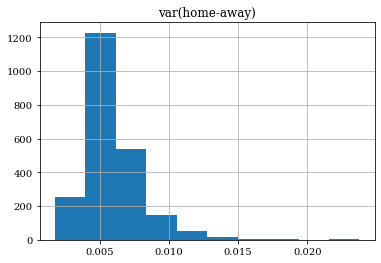

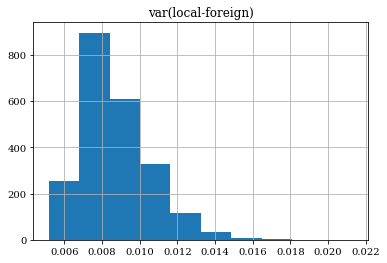

In [16]:
for col in var_la_df.columns:
    var_la_df[col].hist().set_title(col)
    plt.show()

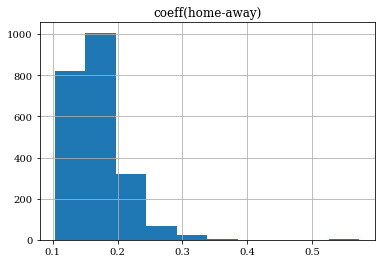

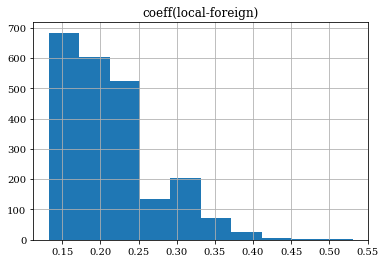

In [17]:
for col in coeff_df:
    coeff_df[col].hist().set_title(col)
    plt.show()

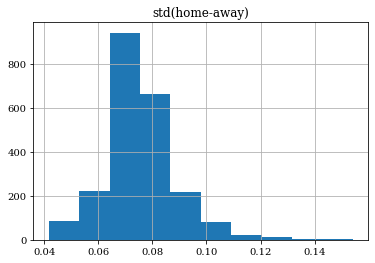

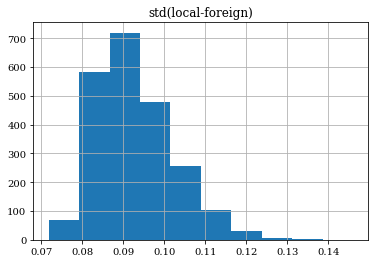

In [18]:
for col in std_la_df:
    std_la_df[col].hist().set_title(col)
    plt.show()

### save

In [19]:
file = '/home/b.lind/offsets/pop_home-away_local_adaptation.txt'

home_away_la_df.to_csv(file, sep='\t', index=True, header=True)

home_away_la_df

1         2         3         4         5         6         7  \
1231094  0.670733  0.646905  0.669739  0.649250  0.643735  0.655245  0.632993   
1231095  0.656732  0.686114  0.687303  0.672272  0.663219  0.666871  0.611360   
1231096  0.615912  0.621110  0.626478  0.629623  0.625628  0.633429  0.621818   
1231097  0.636040  0.611810  0.639919  0.622352  0.618658  0.605645  0.625232   
1231098  0.620525  0.623390  0.614807  0.630053  0.632991  0.655403  0.628759   
...           ...       ...       ...       ...       ...       ...       ...   
1233339  0.201890  0.302877  0.275989  0.252099  0.382505  0.383477  0.318642   
1233340  0.453318  0.313450  0.306338  0.396286  0.553971  0.572114  0.406975   
1233341  0.536871  0.370943  0.236649  0.362055  0.567707  0.609547  0.405525   
1233342  0.540725  0.378965  0.313187  0.415205  0.565347  0.520275  0.414173   
1233343  0.470426  0.408282  0.334241  0.473285  0.586101  0.509083  0.453150   

                8         9        10        11        12        13        14  \
1231094  0.590359  0.615083  0.526406  0.505917  0.551525  0.522348  0.561656   
1231095  0.673245  0.605447  0.605434  0.579667  0.574654  0.583480  0.572254   
1231096  0.613821  0.630609  0.596385  0.547136  0.549917  0.538125  0.542857   
1231097  0.619179  0.631007  0.614218  0.539051  0.532271  0.544069  0.541991   
1231098  0.612643  0.617480  0.646653  0.551102  0.547696  0.561739  0.557277   
...           ...       ...       ...       ...       ...       ...       ...   
1233339  0.248548  0.401652  0.506040  0.267868  0.304536  0.292849  0.333914   
1233340  0.241872  0.270747  0.241674  0.454941  0.394020  0.303520  0.390072   
1233341  0.281288  0.370962  0.596517  0.573586  0.345194  0.273679  0.356794   
1233342  0.300957  0.375718  0.542427  0.554735  0.334069  0.323007  0.420939   
1233343  0.284093  0.353138  0.258114  0.452143  0.418286  0.336927  0.455679   

               15        16        17        18        19        20        21  \
1231094  0.536193  0.559289  0.539436  0.541522  0.509246  0.504307  0.497126   
1231095  0.589824  0.584392  0.576461  0.536331  0.537215  0.475777  0.481494   
1231096  0.543850  0.558272  0.535237  0.554138  0.554122  0.543995  0.489239   
1231097  0.553054  0.557721  0.539310  0.540874  0.538628  0.506879  0.476761   
1231098  0.538334  0.520776  0.536217  0.493979  0.513383  0.478606  0.470774   
...           ...       ...       ...       ...       ...       ...       ...   
1233339  0.445356  0.463029  0.332465  0.247107  0.314077  0.615120  0.227492   
1233340  0.458307  0.530863  0.342430  0.324327  0.261212  0.262610  0.428745   
1233341  0.583422  0.540644  0.357506  0.261500  0.373106  0.545896  0.488211   
1233342  0.491359  0.515948  0.413304  0.314842  0.302900  0.532177  0.544245   
1233343  0.500421  0.508079  0.417813  0.272186  0.378960  0.287687  0.461239   

               22        23        24        25        26        27        28  \
1231094  0.490664  0.488885  0.478090  0.475465  0.480895  0.484853  0.485389   
1231095  0.480888  0.480852  0.490171  0.489197  0.463406  0.455404  0.479455   
1231096  0.476774  0.477878  0.492533  0.477910  0.483365  0.489531  0.487821   
1231097  0.480320  0.482444  0.478066  0.462275  0.467736  0.489752  0.474634   
1231098  0.474717  0.453753  0.481784  0.454083  0.476286  0.464655  0.459720   
...           ...       ...       ...       ...       ...       ...       ...   
1233339  0.337952  0.315142  0.341412  0.492880  0.460808  0.345141  0.271614   
1233340  0.335269  0.289592  0.331457  0.415543  0.374097  0.338090  0.275598   
1233341  0.353006  0.299362  0.335926  0.523742  0.501979  0.356630  0.286637   
1233342  0.333580  0.325729  0.400087  0.467324  0.479347  0.399878  0.334710   
1233343  0.316017  0.284328  0.432428  0.540244  0.526646  0.402995  0.227424   

               29        30        31        32        33        34        35  \
1231094  0.489313  0.461021  0.450333  0.44

In [20]:
file = '/home/b.lind/offsets/pop_local-foreign_local_adaptation.txt'

local_foreign_la_df.to_csv(file, sep='\t', index=True, header=True)

local_foreign_la_df

1         2         3         4         5         6         7  \
1231094  0.658017  0.649082  0.647677  0.648067  0.639580  0.659807  0.637250   
1231095  0.648788  0.653479  0.666079  0.657191  0.631611  0.663516  0.630531   
1231096  0.634458  0.634086  0.635857  0.642654  0.638827  0.634386  0.633544   
1231097  0.627068  0.619266  0.634853  0.627302  0.620626  0.619347  0.631434   
1231098  0.623008  0.639583  0.613558  0.623828  0.625780  0.644268  0.637523   
...           ...       ...       ...       ...       ...       ...       ...   
1233339  0.384207  0.405302  0.340272  0.315802  0.446944  0.459738  0.367552   
1233340  0.534095  0.249922  0.197069  0.300800  0.530129  0.518445  0.354059   
1233341  0.576756  0.377341  0.275308  0.342884  0.579059  0.610467  0.376127   
1233342  0.585543  0.368910  0.337023  0.414055  0.541400  0.530661  0.409990   
1233343  0.553957  0.358002  0.273711  0.423212  0.556643  0.535751  0.397834   

                8         9        10        11        12        13        14  \
1231094  0.620574  0.647344  0.598437  0.521580  0.545369  0.535926  0.544204   
1231095  0.664390  0.647211  0.632305  0.579233  0.583983  0.565957  0.578203   
1231096  0.634470  0.638899  0.624338  0.544784  0.552616  0.549234  0.540854   
1231097  0.635478  0.629211  0.624131  0.549018  0.549176  0.550451  0.542113   
1231098  0.621272  0.634892  0.651107  0.548763  0.554743  0.559216  0.561786   
...           ...       ...       ...       ...       ...       ...       ...   
1233339  0.285044  0.327777  0.535381  0.407927  0.368217  0.319088  0.349696   
1233340  0.275569  0.316799  0.410623  0.487306  0.298641  0.309963  0.383907   
1233341  0.305820  0.398490  0.589865  0.569726  0.364013  0.296827  0.328232   
1233342  0.310235  0.364125  0.581307  0.573971  0.343392  0.331102  0.389808   
1233343  0.265026  0.374894  0.432835  0.552163  0.351790  0.254509  0.388327   

               15        16        17        18        19        20        21  \
1231094  0.544972  0.542711  0.549203  0.538571  0.530185  0.532176  0.489001   
1231095  0.581045  0.585962  0.580421  0.565318  0.559999  0.534706  0.497508   
1231096  0.545595  0.553037  0.541340  0.551553  0.545211  0.534928  0.487814   
1231097  0.546683  0.556836  0.536555  0.532547  0.533064  0.511487  0.471603   
1231098  0.543559  0.530976  0.548543  0.528385  0.525336  0.500916  0.470800   
...           ...       ...       ...       ...       ...       ...       ...   
1233339  0.480926  0.490464  0.363177  0.227497  0.241251  0.553800  0.397795   
1233340  0.506483  0.554571  0.217303  0.306627  0.289293  0.408435  0.462537   
1233341  0.568055  0.550626  0.320364  0.278056  0.417874  0.542254  0.498964   
1233342  0.492759  0.494222  0.372792  0.325937  0.281330  0.579740  0.553718   
1233343  0.509646  0.518938  0.284626  0.202513  0.376017  0.446155  0.545037   

               22        23        24        25        26        27        28  \
1231094  0.486930  0.473090  0.466929  0.467531  0.475651  0.472100  0.477484   
1231095  0.487073  0.492752  0.492426  0.495311  0.475629  0.481049  0.489315   
1231096  0.470004  0.480195  0.489594  0.479058  0.483314  0.483348  0.484491   
1231097  0.482548  0.476064  0.477410  0.462763  0.469665  0.473828  0.469392   
1231098  0.485382  0.458121  0.488498  0.454078  0.480938  0.456782  0.455232   
...           ...       ...       ...       ...       ...       ...       ...   
1233339  0.381035  0.314917  0.327598  0.502833  0.489471  0.338772  0.252013   
1233340  0.271462  0.293488  0.319670  0.469336  0.405116  0.317190  0.294385   
1233341  0.345569  0.305913  0.292935  0.505365  0.505953  0.341872  0.290379   
1233342  0.317674  0.326279  0.379102  0.470368  0.469296  0.385700  0.333562   
1233343  0.253799  0.193728  0.335842  0.523128  0.511981  0.313705  0.148980   

               29        30        31        32        33        34        35  \
1231094  0.470644  0.445749  0.431448  0.43

In [21]:
var_coef_df = pd.concat([var_la_df, coeff_df, std_la_df], axis=1)

var_coef_df.to_csv('/home/b.lind/local_adaptation_var_std_coeff.txt', sep='\t', index=True, header=True)

var_coef_df

var(home-away)  var(local-foreign)  coeff(home-away)  \
1231094        0.006398            0.007387          0.159705   
1231095        0.006800            0.006984          0.163268   
1231096        0.005356            0.006572          0.146588   
1231097        0.005321            0.006183          0.146082   
1231098        0.006009            0.007211          0.154715   
...                 ...                 ...               ...   
1233339        0.008123            0.009677          0.238340   
1233340        0.006248            0.009655          0.204532   
1233341        0.007844            0.008965          0.217606   
1233342        0.008638            0.011132          0.225831   
1233343        0.009338            0.012146          0.266958   

         coeff(local-foreign)  std(home-away)  std(local-foreign)  
1231094              0.171604        0.079989            0.085949  
1231095              0.165466        0.082462            0.083572  
1231096              0.162380        0.073187            0.081071  
1231097              0.157458        0.072948            0.078629  
1231098              0.169483        0.077521            0.084920  
...                       ...             ...                 ...  
1233339              0.260143        0.090126            0.098371  
1233340              0.254247        0.079047            0.098260  
1233341              0.232638        0.088564            0.094681  
1233342              0.256377        0.092938            0.105509  
1233343              0.304461        0.096634            0.110210  

[2250 rows x 6 columns]

<a id='figs'></a>
# Figures

[top](#home)

In [22]:
# add var_LA to params metadata
params = mvp.read_params_file()

for la_type in ['home-away', 'local-foreign']:
    params[f'var({la_type})'] = params.index.map(var_LA[la_type])
    params[f'coeff({la_type})'] = params.index.map(coeff[la_type])
    params[f'std({la_type})'] = params.index.map(std_LA[la_type])
    
params['landscape-slevel-glevel'] = params['landscape-slevel'] + '_' + params['glevel']

params.head(2)

100%|███████████████| 2250/2250 [00:02<00:00, 761.01it/s]


level  reps  \
1231094  highly-polygenic_1-trait__Est-Clines_N-cline-c...     1   
1231095  highly-polygenic_1-trait__Est-Clines_N-cline-N...     1   

                             arch  \
1231094  highly-polygenic_1-trait   
1231095  highly-polygenic_1-trait   

                                           demog_name  \
1231094  Est-Clines_N-cline-center-to-edge_m-constant   
1231095          Est-Clines_N-cline-N-to-S_m-constant   

                           demog_level_sub demog_level  MIG_x  MIG_y  xcline  \
1231094  N-cline-center-to-edge_m-constant  Est-Clines   0.49   0.07  linear   
1231095          N-cline-N-to-S_m-constant  Est-Clines   0.49   0.07  linear   

         ycline    demog  METAPOP_SIDE_x  METAPOP_SIDE_y  Nequal  isVariableM  \
1231094  linear  Estuary              10              10       4            0   
1231095  linear  Estuary              10              10       2            0   

         MIG_breaks arch_level_sub        arch_level       MU_base  \
1231094           0        1-trait  highly-polygenic  1.000000e-07   
1231095           0        1-trait  highly-polygenic  1.000000e-07   

         MU_QTL_proportion  SIGMA_QTN_1  SIGMA_QTN_2  SIGMA_K_1  SIGMA_K_2  \
1231094               0.25        0.002        0.002        0.5        0.5   
1231095               0.25        0.002        0.002        0.5        0.5   

         N_traits  ispleiotropy     seed  final_LA            glevel   plevel  \
1231094         1             0  1231094  0.500854  highly-polygenic  1-trait   
1231095         1             0  1231095  0.505075  highly-polygenic  1-trait   

                 pleio slevel   landscape                 popsize   migration  \
1231094  no pleiotropy    NaN  Est-Clines  N-cline-center-to-edge  m-constant   
1231095  no pleiotropy    NaN  Est-Clines          N-cline-N-to-S  m-constant   

           landscape-slevel  var(home-away)  coeff(home-away)  std(home-away)  \
1231094  Est-Clines_1-trait        0.006398          0.159705        0.079989   
1231095  Est-Clines_1-trait        0.006800          0.163268        0.082462   

         var(local-foreign)  coeff(local-foreign)  std(local-foreign)  \
1231094            0.007387              0.171604            0.085949   
1231095            0.006984              0.165466            0.083572   

                     landscape-slevel-glevel  
1231094  Est-Clines_1-trait_highly-polygenic  
1231095  Est-Clines_1-trait_highly-polygenic

<a id='deg_v_var'></a>
## degree of LA vs var(LA)

[top](#home)

In [23]:
# update metadata so I can create figures

mvp.markers.update(
    {
        'oligogenic' : 'v',  # triangle down
        'mod-polygenic' : 'p',   # pentagon
        'highly-polygenic' : '^'  # triangle up
    }
)

for level in sorted(params['landscape-slevel-glevel'].unique()):
    glevel = level.split("_")[-1]
    landscape_slevel = level.rstrip(f'_{glevel}')
    
    mvp.markers.update({level : mvp.markers[glevel]})
    
    mvp.boxplot_kwargs['palette'].update({level : mvp.boxplot_kwargs['palette'][landscape_slevel]})

Saved to:  /work/lotterhos/MVP-Offsets/run_20220919/summaries/figs/00_estimate_var_LA/final_la_vs_var_home-away.pdf


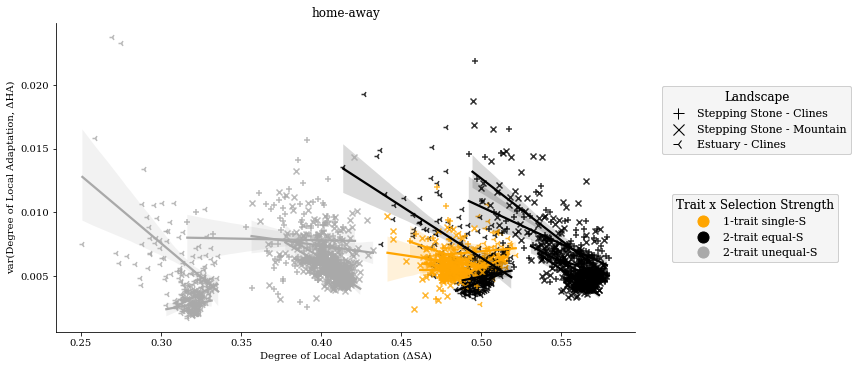

Saved to:  /work/lotterhos/MVP-Offsets/run_20220919/summaries/figs/00_estimate_var_LA/final_la_vs_std_home-away.pdf


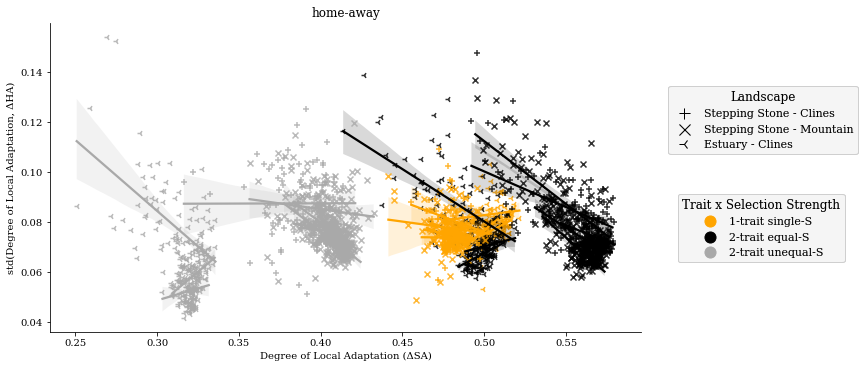

Saved to:  /work/lotterhos/MVP-Offsets/run_20220919/summaries/figs/00_estimate_var_LA/final_la_vs_var_local-foreign.pdf


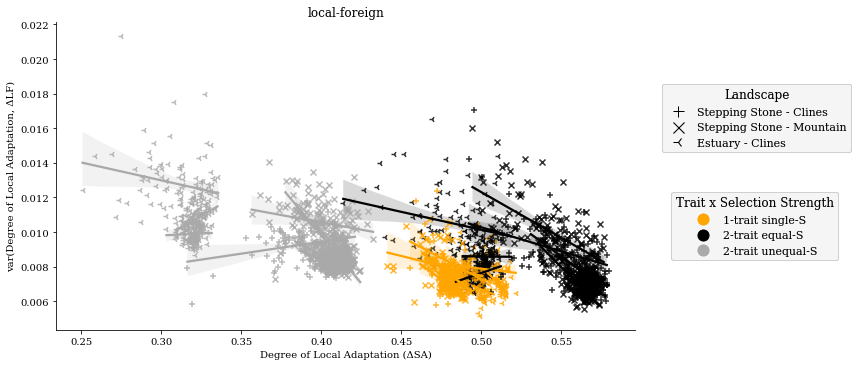

Saved to:  /work/lotterhos/MVP-Offsets/run_20220919/summaries/figs/00_estimate_var_LA/final_la_vs_std_local-foreign.pdf


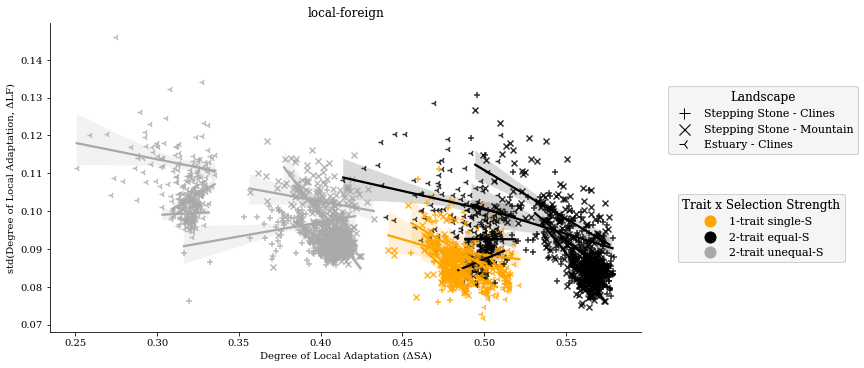

In [24]:
# separate landscape and trait x selection in legend
hue = 'landscape-slevel-glevel'
levels = sorted(params[hue].unique())

la_name = {
    'home-away' : 'ΔHA',
    'local-foreign' : 'ΔLF'
}

for la_type in ['home-away', 'local-foreign']:
    for measure in ['var', 'std']:
        g = sns.lmplot(
            data=params,
            x='final_LA',
            y=f'{measure}({la_type})',
            hue=hue,
            hue_order=levels,
            palette=mvp.boxplot_kwargs['palette'],
            markers=pd.Series(levels).str.split('_', expand=True)[0].map(mvp.markers).tolist(),
            legend=False
        )

        g.figure.set_size_inches(10, 5)

        g.set(ylabel=f'{measure}(Degree of Local Adaptation, {la_name[la_type]})',
              xlabel='Degree of Local Adaptation (ΔSA)',
              title=la_type
             )

    #     mvp.add_legend(g.figure, color_by=hue, use_markers=True, loc='center left', bbox_to_anchor=(1, 0.55))# ncol=3, loc='lower center', bbox_to_anchor=(0.55, 1))
        mvp.add_legend(g.figure, color_by='landscape', use_markers=True, markeredgecolor='k',
                       loc='center left', bbox_to_anchor=(1, 0.7))

        mvp.add_legend(g.figure, color_by='slevel_plus1', loc='center left', bbox_to_anchor=(1.013, 0.4))

        save_pdf(f'{figdir}/final_la_vs_{measure}_{la_type}.pdf')

        plt.show()

Saved to:  /work/lotterhos/MVP-Offsets/run_20220919/summaries/figs/00_estimate_var_LA/final_la_vs_var_home-away_by_glevel.pdf


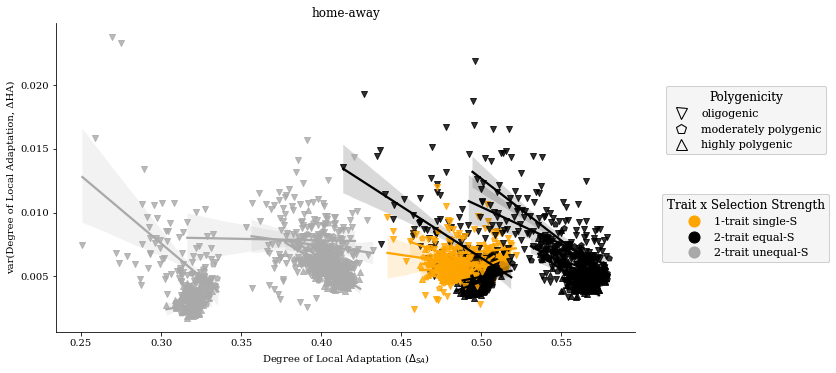

Saved to:  /work/lotterhos/MVP-Offsets/run_20220919/summaries/figs/00_estimate_var_LA/final_la_vs_std_home-away_by_glevel.pdf


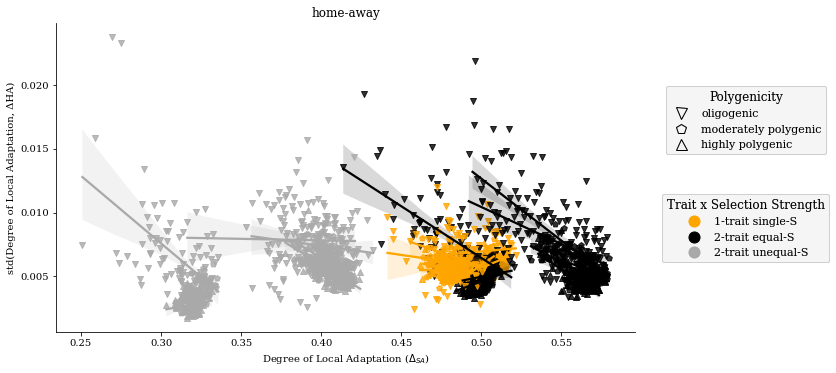

Saved to:  /work/lotterhos/MVP-Offsets/run_20220919/summaries/figs/00_estimate_var_LA/final_la_vs_var_local-foreign_by_glevel.pdf


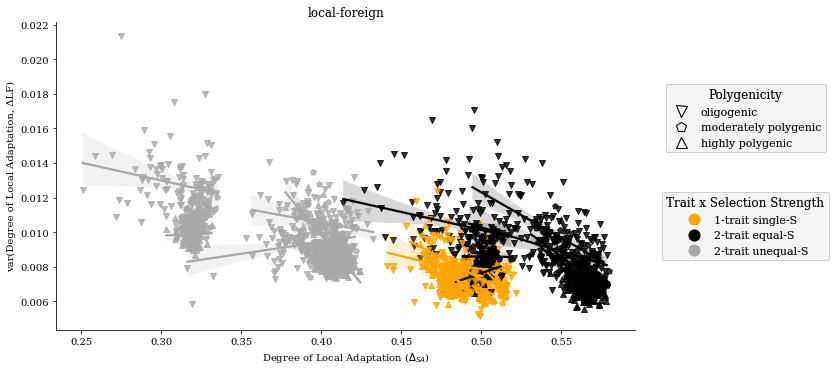

Saved to:  /work/lotterhos/MVP-Offsets/run_20220919/summaries/figs/00_estimate_var_LA/final_la_vs_std_local-foreign_by_glevel.pdf


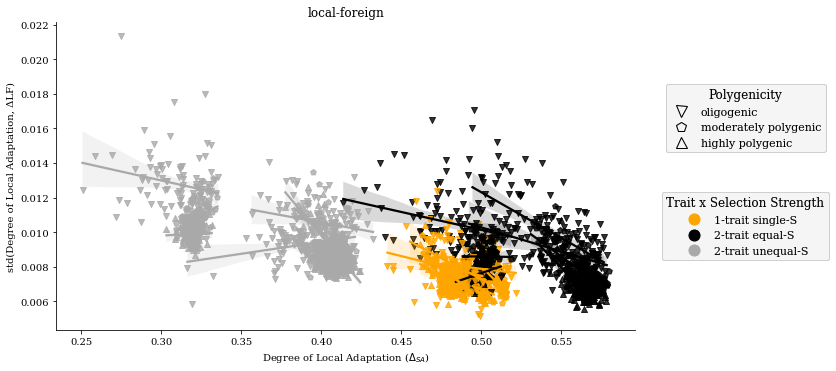

In [25]:
# separate landscape and trait x selection in legend
hue = 'landscape-slevel-glevel'
levels = sorted(params[hue].unique())

for la_type in ['home-away', 'local-foreign']:
    for measure in ['var', 'std']:
        g = sns.lmplot(
            data=params,
            x='final_LA',
            y=f'var({la_type})',
            hue=hue,
            hue_order=levels,
            palette=mvp.boxplot_kwargs['palette'],
            markers=pd.Series(levels).map(mvp.markers).tolist(),
            legend=False
        )

        g.figure.set_size_inches(10, 5)

        g.set(ylabel=f'{measure}(Degree of Local Adaptation, {la_name[la_type]})',
              xlabel='Degree of Local Adaptation ($Δ_{SA}$)',
              title=la_type
             )

        mvp.add_legend(g.figure, color_by='glevel', use_markers=True, markeredgecolor='k',
                       loc='center left', bbox_to_anchor=(1.005, 0.7), legendmarkerfacecolor='none')

        mvp.add_legend(g.figure, color_by='slevel_plus1', loc='center left', bbox_to_anchor=(1, 0.4))

        save_pdf(f'{figdir}/final_la_vs_{measure}_{la_type}_by_glevel.pdf')

        plt.show()


<a id='boxplots'></a>
## boxplots of factors influencing var(LA)

[top](#home)

In [26]:
# annotate std_la_df
copy = std_la_df.copy()
for hue, hue_order in mvp.hue_order.items():
    if hue in ['noncausal_env', 'marker_set', 'program', 'demography']:
        continue
    
    copy[hue] = copy.index.to_series().map(params[hue])
    
copy['demography'] = copy['popsize'] + '_' + copy['migration']
copy['landscape-slevel'] = copy.index.map(params['landscape-slevel'])

copy.head(1)

std(home-away)  std(local-foreign)   landscape            glevel  \
1231094        0.079989            0.085949  Est-Clines  highly-polygenic   

                 pleio slevel                 popsize   migration  \
1231094  no pleiotropy    NaN  N-cline-center-to-edge  m-constant   

                                demography    landscape-slevel  
1231094  N-cline-center-to-edge_m-constant  Est-Clines_1-trait

In [27]:
for level in params['landscape-slevel'].unique():  # godzilla 2
    landscape, slevel = level.split("_")
    
    if slevel == '1-trait':
        slevel = 'single-trait'
    else:
        slevel = mvp.factor_names[slevel]
    
    landscape = mvp.factor_names[landscape]
    
    
    mvp.factor_names[level] = f'{landscape} {slevel}'

In [28]:
mvp.factor_names['SS-Clines_equal-S']

'Stepping Stone - Clines equal-S'

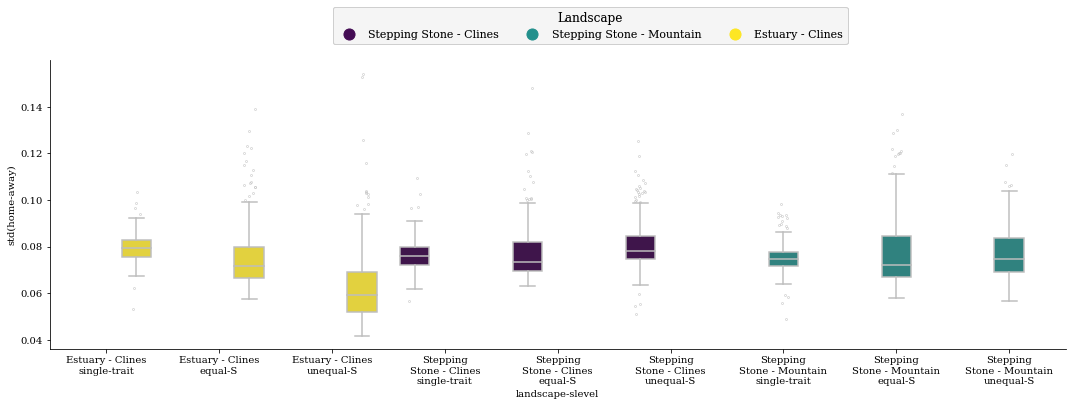

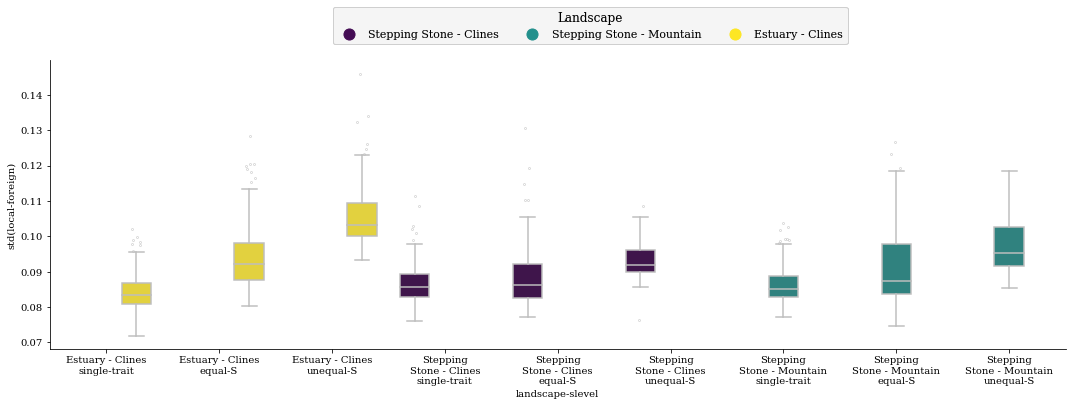

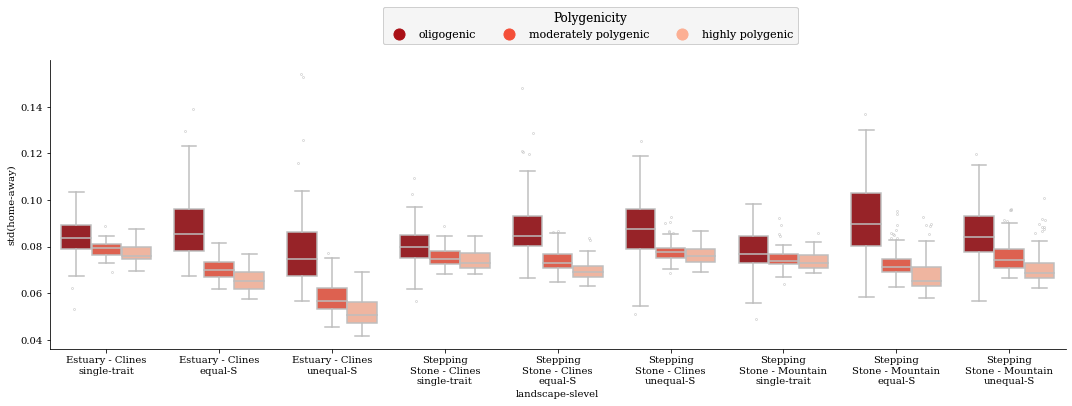

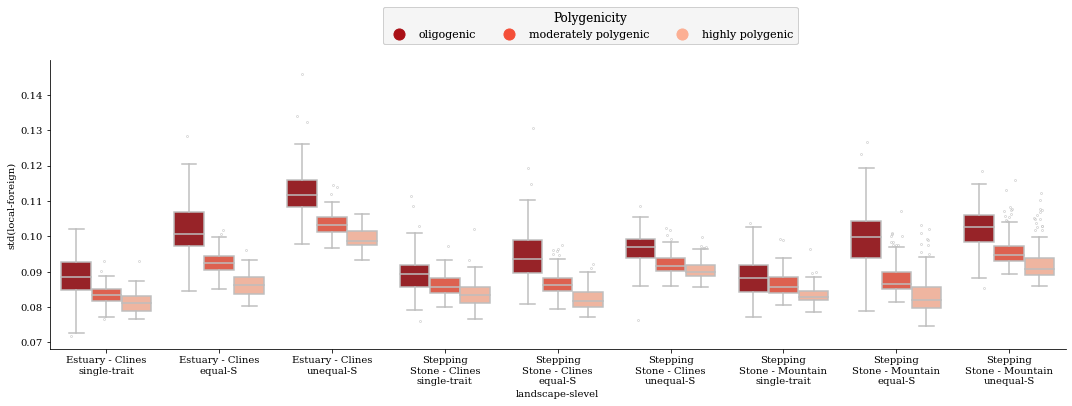

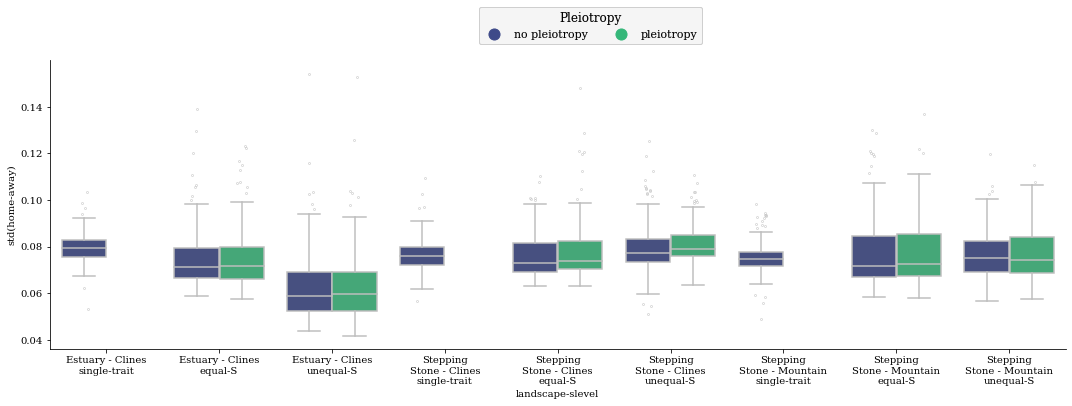

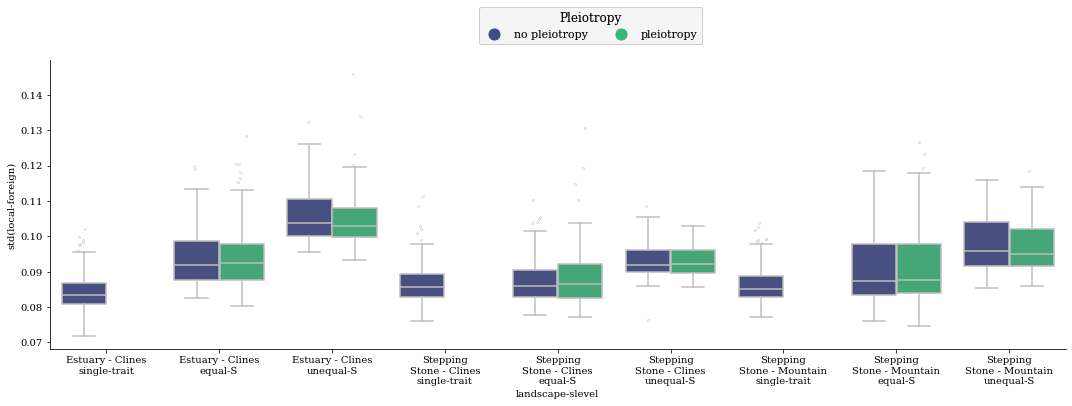

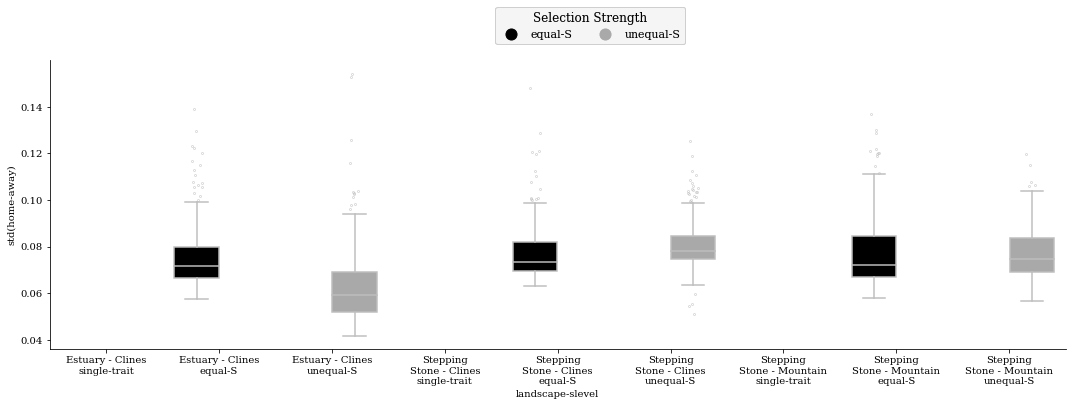

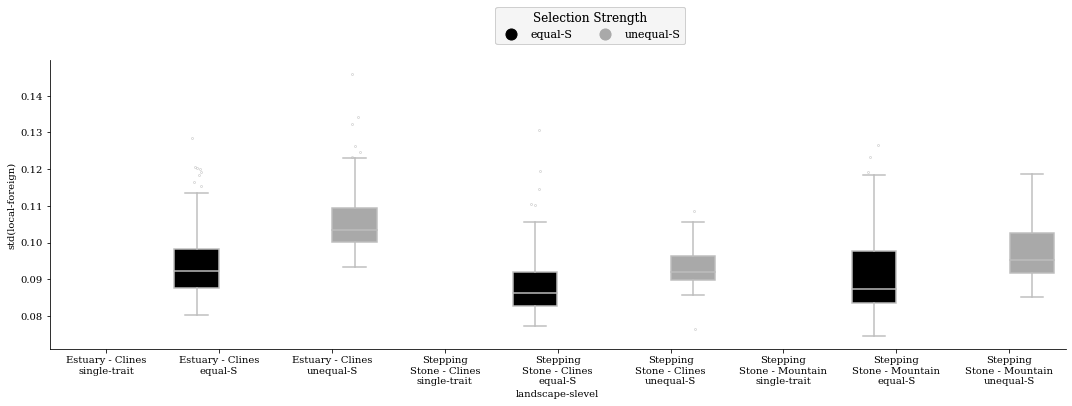

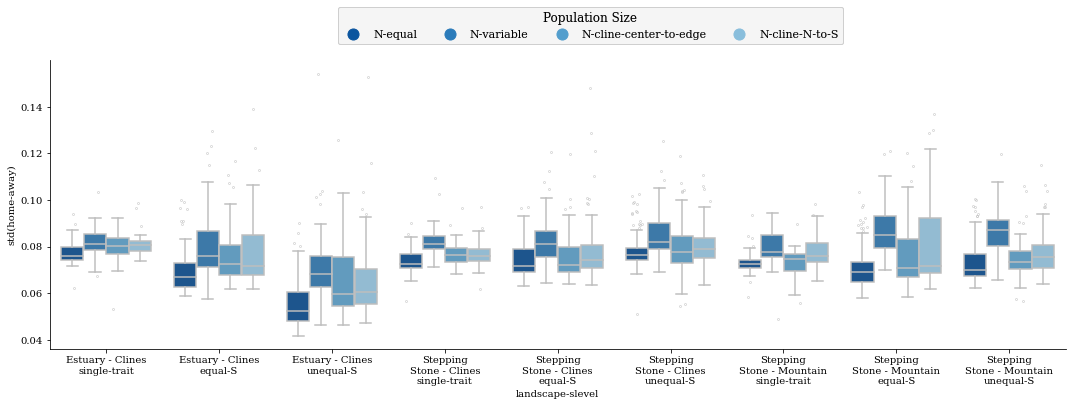

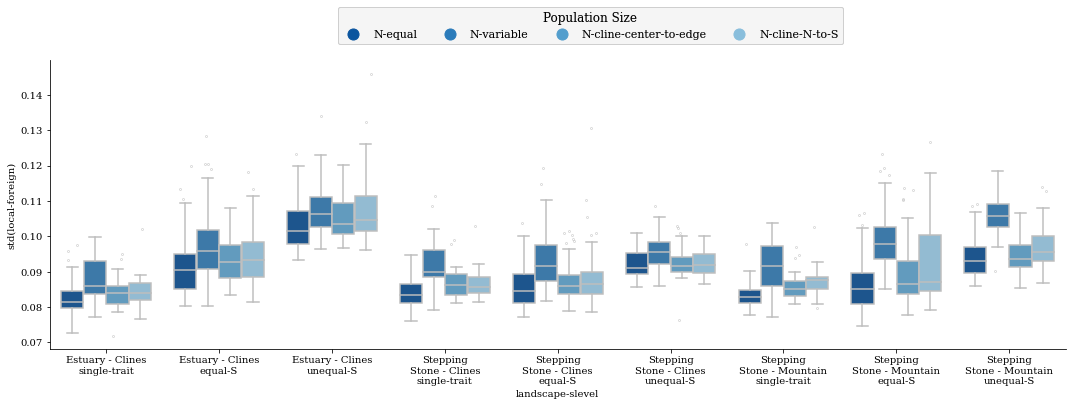

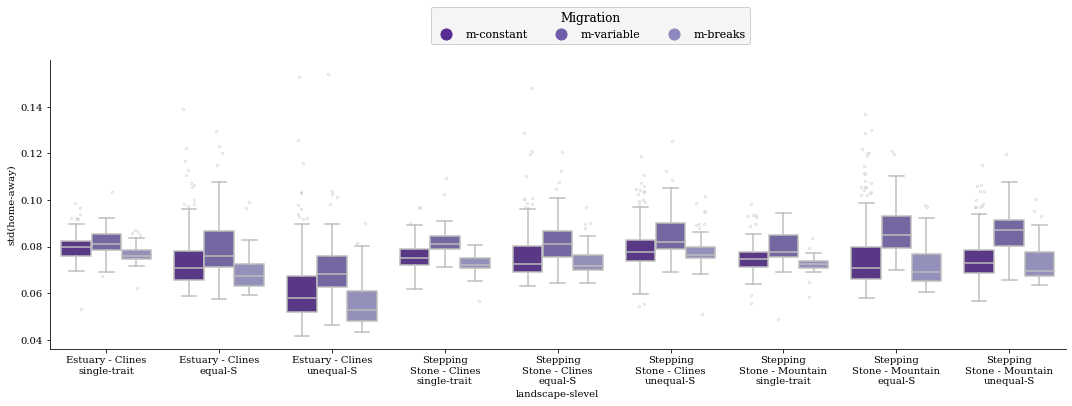

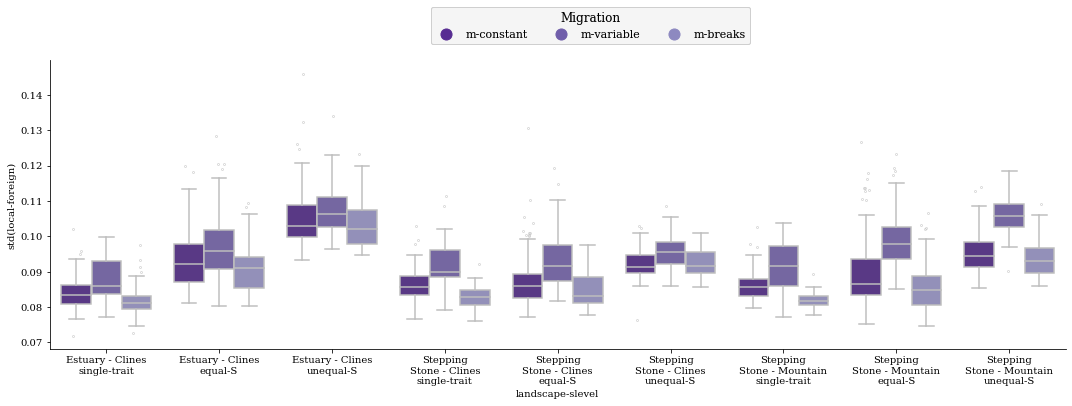

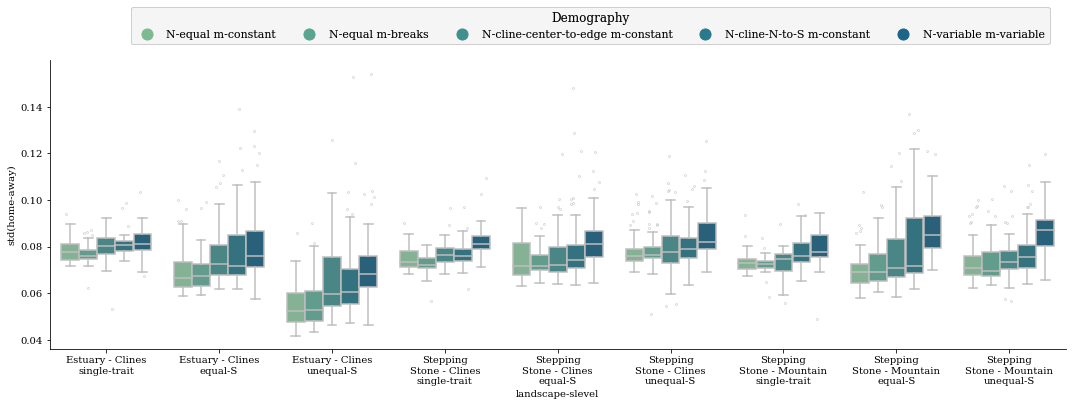

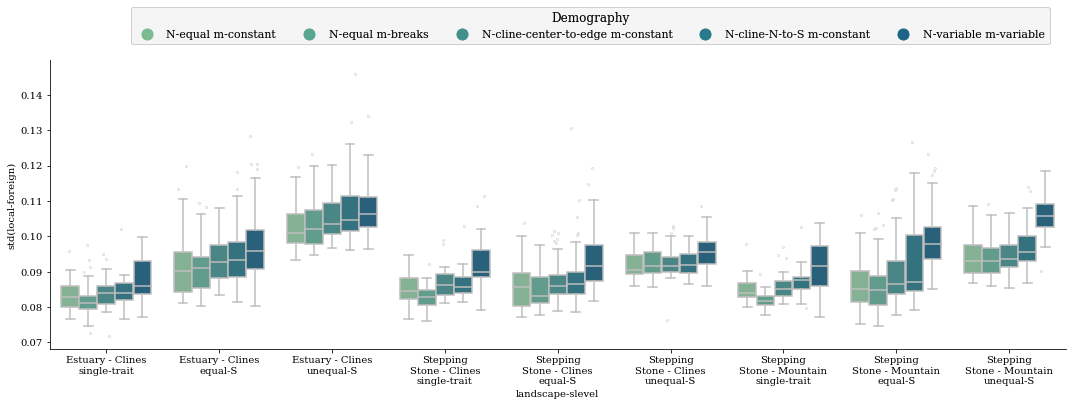

In [29]:
# boxplot of which levels have more var_la
for hue, hue_order in mvp.hue_order.items():
    for var_la_type in std_la_df.columns:
        if hue in ['noncausal_env', 'marker_set', 'program']:
            continue

        g = sns.catplot(
            data=copy,
            x='landscape-slevel',
            order=sorted(params['landscape-slevel'].unique()),
            y=var_la_type,
            hue=hue,
            hue_order=hue_order,
            **mvp.boxplot_kwargs,
            kind='box',
            legend=False
        )
        
        g.figure.set_size_inches(15, 5)
        
        mvp.jitter_fliers(g)
        
        mvp.update_ticklabels(g.ax, replace=[(' ', '\n'), ('\n-\n', ' - ')])
        
        mvp.add_legend(g.figure, color_by=hue, ncol='auto', loc='lower center', bbox_to_anchor=(0.55, 1))
        
        plt.tight_layout()
        
        plt.show()

<a id='anova'></a>
# ANOVA

what is primary cause of var(LA)?

[top](#home)

In [30]:
def print_summary_table(lm):
    """Do lm.summary2().__repr__() but just display the first table in lm.summary2().tables.
    
    summary - return from lm.summary2()
    """
    from statsmodels.iolib.summary2 import _simple_tables, _measure_tables

    summary = lm.summary2()
    
    tables = [summary.tables[0]]
    settings = [summary.settings[0]]
    pad_col, pad_index, widest = _measure_tables(tables, settings)
    rule_equal = widest * '='

    simple_tables = _simple_tables(tables, settings, pad_col, pad_index)
    tab = [x.as_text() for x in simple_tables]

    tab = '\n'.join(tab)
    tab = tab.split('\n')
    tab[0] = rule_equal
    tab.append(rule_equal)
    tab = '\n'.join(tab)
    
    print(tab)
    
    pass


def get_anova(formula_key, typ=None):
    """Estimate ANOVA using evolutionary parameters as factors.
    
    Parameters
    ----------
    formula_key : str
        used to index formulas just above
    typ : int
        the Type of ANOVA - 1, 2, or 3
    
    Notes
    -----
    - displays statistical info from ANOVA and qqplot
    - C(factor) treats a numerical entry as a category (gardens are integer IDs)
    """
    # determine formula
    formula = formulas[formula_key]
    
    # determine Type of ANOVA
    if typ is None:
        typ = 3 if 'interaction' in formula_key else 2
    
#     # get anovas
#     lms = {}
#     res = {}
    sos = []
       
#     for program in bcs_garden_data.program.unique():
#         _df = bcs_garden_data[bcs_garden_data.program == program].copy()

#         print(f'\n{ColorText(formula_key).bold()} {ColorText(formula).blue()}')
#         print(f'{ColorText(program).green().bold()}')

    # perform type 2 anova
    lms = ols(formula, data=anova_df).fit()
    res = anova_lm(lms, typ=typ)

    # get percentages for sum of squares
    res['perc_sum_sq'] = (
        (
            (res['sum_sq'] / res['sum_sq'].sum()) * 100
        ).round(2)
    )
    if round(abs(res['perc_sum_sq'].sum() - 100), 2) > 0.03:  # account for compounding error rounding percs
        raise Exception('bad percentage', abs(res['perc_sum_sq'].sum() - 100))

#         res[program].index = res[program].index.map(mvp.factor_names)

    # brown-forsythe test?
    # TODO?

    # show more info
    display(res)
    print_summary_table(lms)

    sm.qqplot(lms.resid, line="45")
    plt.show()

    # get sum of squares
    sos.append(
        pd.Series(
            res['sum_sq'].tolist(),
#             name=program,
            index=res['sum_sq'].index#.map(mvp.factor_names)
        )
    )

    return lms, res, sos

In [31]:
anova_df = var_la_df.copy()
anova_df.columns = ['var_ha', 'var_lf']  # need to change to avoid errors from anova inner parsing
for param in mvp.hue_order:
    if param in ['demography', 'noncausal_env', 'marker_set', 'program']:
        continue
        
    anova_df[param] = anova_df.index.map(params[param])
    
anova_df['demography'] = anova_df['popsize'] + '_' + anova_df['migration']
    
anova_df 

var_ha    var_lf   landscape            glevel          pleio  \
1231094  0.006398  0.007387  Est-Clines  highly-polygenic  no pleiotropy   
1231095  0.006800  0.006984  Est-Clines  highly-polygenic  no pleiotropy   
1231096  0.005356  0.006572  Est-Clines  highly-polygenic  no pleiotropy   
1231097  0.005321  0.006183  Est-Clines  highly-polygenic  no pleiotropy   
1231098  0.006009  0.007211  Est-Clines  highly-polygenic  no pleiotropy   
...           ...       ...         ...               ...            ...   
1233339  0.008123  0.009677      SS-Mtn        oligogenic     pleiotropy   
1233340  0.006248  0.009655      SS-Mtn        oligogenic     pleiotropy   
1233341  0.007844  0.008965      SS-Mtn        oligogenic     pleiotropy   
1233342  0.008638  0.011132      SS-Mtn        oligogenic     pleiotropy   
1233343  0.009338  0.012146      SS-Mtn        oligogenic     pleiotropy   

            slevel                 popsize   migration  \
1231094        NaN  N-cline-center-to-edge  m-constant   
1231095        NaN          N-cline-N-to-S  m-constant   
1231096        NaN                 N-equal    m-breaks   
1231097        NaN                 N-equal  m-constant   
1231098        NaN              N-variable  m-variable   
...            ...                     ...         ...   
1233339  unequal-S  N-cline-center-to-edge  m-constant   
1233340  unequal-S          N-cline-N-to-S  m-constant   
1233341  unequal-S                 N-equal    m-breaks   
1233342  unequal-S                 N-equal  m-constant   
1233343  unequal-S              N-variable  m-variable   

                                demography  
1231094  N-cline-center-to-edge_m-constant  
1231095          N-cline-N-to-S_m-constant  
1231096                   N-equal_m-breaks  
1231097                 N-equal_m-constant  
1231098              N-variable_m-variable  
...                                    ...  
1233339  N-cline-center-to-edge_m-constant  
1233340          N-cline-N-to-S_m-constant  
1233341                   N-equal_m-breaks  
1233342                 N-equal_m-constant  
1233343              N-variable_m-variable  

[2250 rows x 9 columns]

In [32]:
factors = ' + '.join(anova_df.columns[2:-1])
factors2 = ' + '.join(['landscape', 'glevel', 'pleio', 'slevel', 'demography'])

formulas = {}
for la_type in ['var_ha', 'var_lf']:
    for i, factorset in enumerate([factors, factors2]):
        formulas[f'{la_type}_{i+1}'] = f'var_ha ~ {factorset}'

formulas

{'var_ha_1': 'var_ha ~ landscape + glevel + pleio + slevel + popsize + migration',
 'var_ha_2': 'var_ha ~ landscape + glevel + pleio + slevel + demography',
 'var_lf_1': 'var_ha ~ landscape + glevel + pleio + slevel + popsize + migration',
 'var_lf_2': 'var_ha ~ landscape + glevel + pleio + slevel + demography'}

var_ha_1


sum_sq      df           F         PR(>F)  perc_sum_sq
landscape  0.000631     2.0  115.490406   6.711812e-48         6.39
glevel     0.003234     2.0  591.894563  5.183927e-198        32.77
pleio      0.000006     1.0    2.166667   1.412075e-01         0.06
slevel     0.000073     1.0   26.548432   2.854068e-07         0.73
popsize    0.000933     3.0  113.816011   1.882819e-67         9.45
migration  0.000106     2.0   19.368116   4.767655e-09         1.07
Residual   0.004887  1789.0         NaN            NaN        49.52

Model:              OLS              Adj. R-squared:     0.500      
Dependent Variable: var_ha           AIC:                -17939.9237
Date:               2023-12-21 13:05 BIC:                -17879.4727
No. Observations:   1800             Log-Likelihood:     8981.0     
Df Model:           10               F-statistic:        180.7      
Df Residuals:       1789             Prob (F-statistic): 9.34e-263  
R-squared:          0.503            Scale:              2.7317e-06 


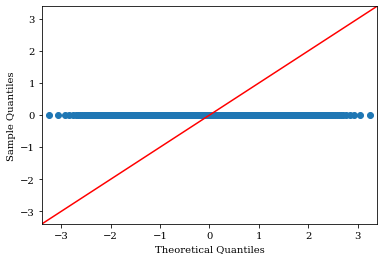

var_ha_2


sum_sq      df           F         PR(>F)  perc_sum_sq
landscape   0.000631     2.0  115.490406   6.711812e-48         6.42
glevel      0.003234     2.0  591.894563  5.183927e-198        32.92
pleio       0.000006     1.0    2.166667   1.412075e-01         0.06
slevel      0.000073     1.0   26.548432   2.854068e-07         0.74
demography  0.000994     4.0   90.986443   1.755077e-70        10.12
Residual    0.004887  1789.0         NaN            NaN        49.74

Model:              OLS              Adj. R-squared:     0.500      
Dependent Variable: var_ha           AIC:                -17939.9237
Date:               2023-12-21 13:05 BIC:                -17879.4727
No. Observations:   1800             Log-Likelihood:     8981.0     
Df Model:           10               F-statistic:        180.7      
Df Residuals:       1789             Prob (F-statistic): 9.34e-263  
R-squared:          0.503            Scale:              2.7317e-06 


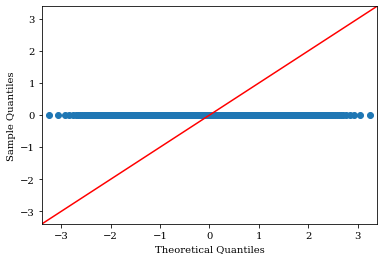

var_lf_1


sum_sq      df           F         PR(>F)  perc_sum_sq
landscape  0.000631     2.0  115.490406   6.711812e-48         6.39
glevel     0.003234     2.0  591.894563  5.183927e-198        32.77
pleio      0.000006     1.0    2.166667   1.412075e-01         0.06
slevel     0.000073     1.0   26.548432   2.854068e-07         0.73
popsize    0.000933     3.0  113.816011   1.882819e-67         9.45
migration  0.000106     2.0   19.368116   4.767655e-09         1.07
Residual   0.004887  1789.0         NaN            NaN        49.52

Model:              OLS              Adj. R-squared:     0.500      
Dependent Variable: var_ha           AIC:                -17939.9237
Date:               2023-12-21 13:05 BIC:                -17879.4727
No. Observations:   1800             Log-Likelihood:     8981.0     
Df Model:           10               F-statistic:        180.7      
Df Residuals:       1789             Prob (F-statistic): 9.34e-263  
R-squared:          0.503            Scale:              2.7317e-06 


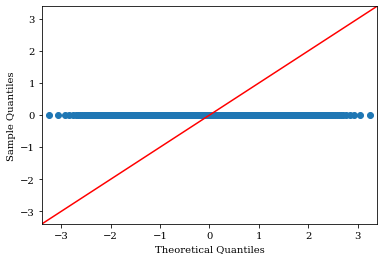

var_lf_2


sum_sq      df           F         PR(>F)  perc_sum_sq
landscape   0.000631     2.0  115.490406   6.711812e-48         6.42
glevel      0.003234     2.0  591.894563  5.183927e-198        32.92
pleio       0.000006     1.0    2.166667   1.412075e-01         0.06
slevel      0.000073     1.0   26.548432   2.854068e-07         0.74
demography  0.000994     4.0   90.986443   1.755077e-70        10.12
Residual    0.004887  1789.0         NaN            NaN        49.74

Model:              OLS              Adj. R-squared:     0.500      
Dependent Variable: var_ha           AIC:                -17939.9237
Date:               2023-12-21 13:05 BIC:                -17879.4727
No. Observations:   1800             Log-Likelihood:     8981.0     
Df Model:           10               F-statistic:        180.7      
Df Residuals:       1789             Prob (F-statistic): 9.34e-263  
R-squared:          0.503            Scale:              2.7317e-06 


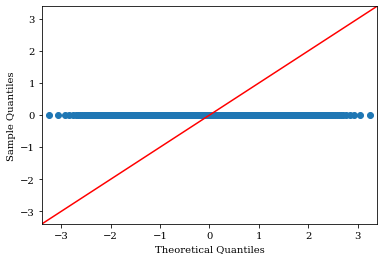

In [33]:
lms = {}; res = {}; sos = {}
for la_type in formulas:
    print(ColorText(la_type).bold())
    lms, res, sos = get_anova(la_type)

<a id='perf'></a>
# Performance vs var(LA)

[top](#home)

### get data

In [34]:
# read in data
program_data = mvp.subset_data_scores(
    mvp.combine_level_dicts(use_bcs_data=False, keep_nuisance=False),
    apply_median=True,
    bcs=False,
    keep_nuisance=False,
    marker_set='all'
)

filtering criteria:
	use_bcs_data = False
	performance = garden_performance
	num_traits = None
	ntraits = None
	marker_set = None
	remove_structcrxn = False
	keep_nuisance = False
	remove_rda_outliers = True


reading reps: 100%|███████████████| 10/10 [00:27<00:00,  2.80s/it]


0-225
	 RONA num seeds =  225
	 lfmm2 num seeds =  225
	 GF num seeds =  225
	 rda num seeds =  225


225-450
	 RONA num seeds =  225
	 lfmm2 num seeds =  225
	 GF num seeds =  225
	 rda num seeds =  225


450-675
	 RONA num seeds =  225
	 lfmm2 num seeds =  225
	 GF num seeds =  225
	 rda num seeds =  225


675-900
	 RONA num seeds =  225
	 lfmm2 num seeds =  225
	 GF num seeds =  225
	 rda num seeds =  225


900-1125
	 RONA num seeds =  225
	 lfmm2 num seeds =  225
	 GF num seeds =  225
	 rda num seeds =  225


1125-1350
	 RONA num seeds =  225
	 lfmm2 num seeds =  225
	 GF num seeds =  225
	 rda num seeds =  225


1350-1575
	 RONA num seeds =  225
	 lfmm2 num seeds =  225
	 GF num seeds =  225
	 rda num seeds =  225


1575-1800
	 RONA num seeds =  225
	 lfmm2 num seeds =  225
	 GF num seeds =  225
	 rda num seeds =  225


1800-2025
	 RONA num seeds =  225
	 lfmm2 num seeds =  225
	 GF num seeds =  225
	 rda num seeds =  225


2025-2250
	 RONA num seeds =  225
	 lfmm2 num seeds =  22

In [35]:
# combine program data into single dataframe
all_data = pd.DataFrame(columns=['seed', 'program', 'score', 'shape', 'landscape'])
for program, seed_scores in program_data.items():  # seed_scores is pd.Series w/index=seed & value=score; name='score'
    seeddf = pd.DataFrame(seed_scores)
    seeddf['program'] = program
    seeddf['seed'] = seeddf.index.tolist()
    all_data = all_data.append(seeddf)

    
for la_type in ['home-away', 'local-foreign']:
    for stat in ['var', 'coeff', 'std']:
        col = f'{stat}({la_type})'
        all_data[col] = all_data.index.map(params[col])
    
all_data['landscape'] = all_data.index.map(params.landscape)
all_data['shape'] = all_data.program.map(mvp.markers)
all_data['slevel'] = all_data.index.map(params.slevel)
all_data['landscape-slevel'] = all_data['landscape'] + '_' + all_data['slevel'].fillna('1-trait')
all_data['final_LA'] = all_data.index.map(params.final_LA)

all_data

seed         program     score shape   landscape  var(home-away)  \
1231109  1231109    RONA-sal_opt -0.342424     <  Est-Clines        0.004791   
1231110  1231110    RONA-sal_opt -0.440000     <  Est-Clines        0.005026   
1231111  1231111    RONA-sal_opt -0.365455     <  Est-Clines        0.003916   
1231112  1231112    RONA-sal_opt -0.346263     <  Est-Clines        0.003675   
1231113  1231113    RONA-sal_opt -0.222424     <  Est-Clines        0.005023   
...          ...             ...       ...   ...         ...             ...   
1233339  1233339  rda-structcorr -0.248048     D      SS-Mtn        0.008123   
1233340  1233340  rda-structcorr -0.510317     D      SS-Mtn        0.006248   
1233341  1233341  rda-structcorr -0.728889     D      SS-Mtn        0.007844   
1233342  1233342  rda-structcorr -0.345526     D      SS-Mtn        0.008638   
1233343  1233343  rda-structcorr -0.655571     D      SS-Mtn        0.009338   

         coeff(home-away)  std(home-away)  var(local-foreign)  \
1231109          0.138071        0.069219            0.007715   
1231110          0.143672        0.070894            0.007577   
1231111          0.124734        0.062576            0.006971   
1231112          0.121808        0.060619            0.006973   
1231113          0.138372        0.070874            0.007713   
...                   ...             ...                 ...   
1233339          0.238340        0.090126            0.009677   
1233340          0.204532        0.079047            0.009655   
1233341          0.217606        0.088564            0.008965   
1233342          0.225831        0.092938            0.011132   
1233343          0.266958        0.096634            0.012146   

         coeff(local-foreign)  std(local-foreign)     slevel  \
1231109              0.175206            0.087836    equal-S   
1231110              0.176399            0.087043    equal-S   
1231111              0.166430            0.083494    equal-S   
1231112              0.167797            0.083506    equal-S   
1231113              0.171466            0.087824    equal-S   
...                       ...                 ...        ...   
1233339              0.260143            0.098371  unequal-S   
1233340              0.254247            0.098260  unequal-S   
1233341              0.232638            0.094681  unequal-S   
1233342              0.256377            0.105509  unequal-S   
1233343              0.304461            0.110210  unequal-S   

           landscape-slevel  final_LA  
1231109  Est-Clines_equal-S  0.501332  
1231110  Est-Clines_equal-S  0.493447  
1231111  Est-Clines_equal-S  0.501673  
1231112  Est-Clines_equal-S  0.497658  
1231113  Est-Clines_equal-S  0.512199  
...                     ...       ...  
1233339    SS-Mtn_unequal-S  0.378143  
1233340    SS-Mtn_unequal-S  0.386475  
1233341    SS-Mtn_unequal-S  0.406991  
1233342    SS-Mtn_unequal-S  0.411540  
1233343    SS-Mtn_unequal-S  0.361984  

[13050 rows x 14 columns]

In [36]:
all_data.slevel.unique()

array(['equal-S', 'unequal-S', nan], dtype=object)

### make figs

In [37]:
# reported in ms
params['var(home-away)'].median(), params['var(local-foreign)'].median()

(0.005483386049712831, 0.008338495232192062)

In [38]:
# reported in ms
params['std(home-away)'].median(), params['std(local-foreign)'].median()

(0.07404988885738956, 0.09131536140953793)

Saved to:  /work/lotterhos/MVP-Offsets/run_20220919/summaries/figs/00_estimate_var_LA/median_peformance_vs_var_la_home-away.pdf


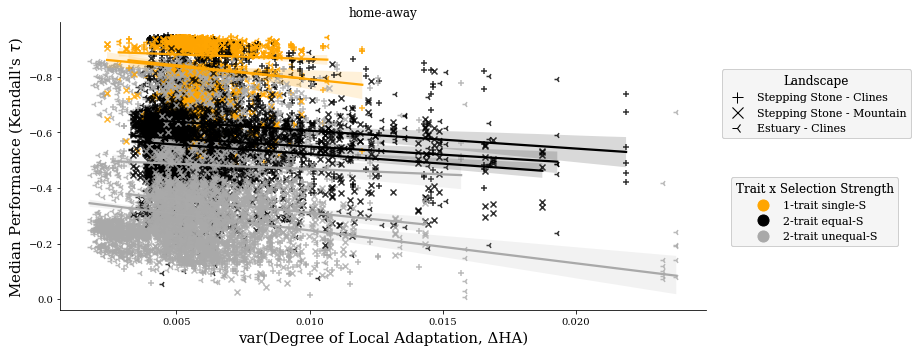

Saved to:  /work/lotterhos/MVP-Offsets/run_20220919/summaries/figs/00_estimate_var_LA/median_peformance_vs_std_la_home-away.pdf


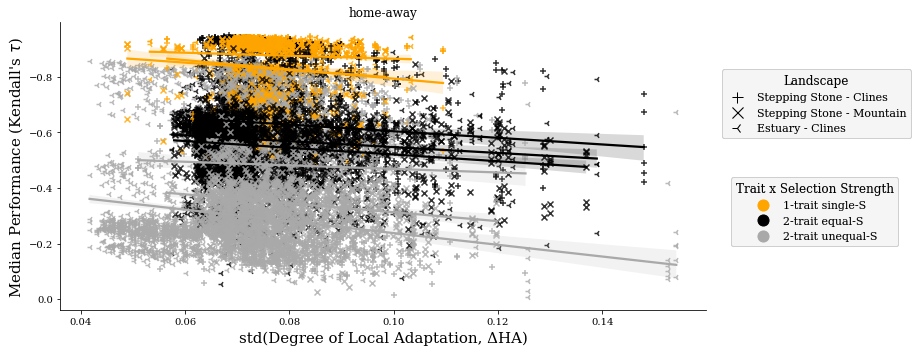

Saved to:  /work/lotterhos/MVP-Offsets/run_20220919/summaries/figs/00_estimate_var_LA/median_peformance_vs_var_la_local-foreign.pdf


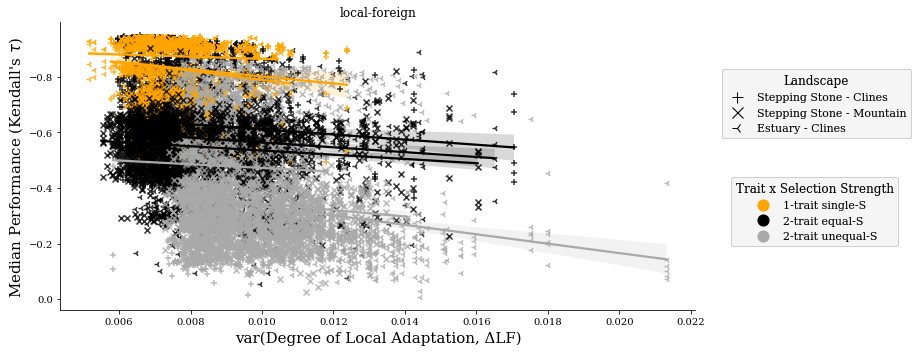

Saved to:  /work/lotterhos/MVP-Offsets/run_20220919/summaries/figs/00_estimate_var_LA/median_peformance_vs_std_la_local-foreign.pdf


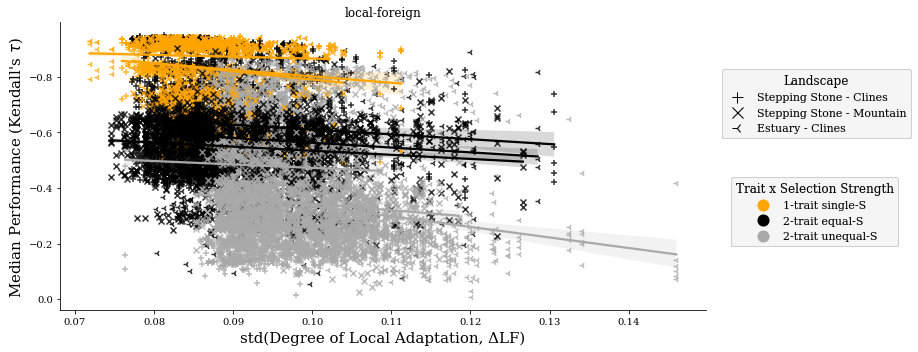

In [39]:
# separate slevels by program
levels = sorted(all_data['landscape-slevel'].unique())

for la_type in ['home-away', 'local-foreign']:
    for measure in ['var', 'std']:
        g = sns.lmplot(
            data=all_data,
            x=f'{measure}({la_type})',
            y='score',
            hue='landscape-slevel',
            hue_order=levels,
            palette=mvp.boxplot_kwargs['palette'],
            markers=pd.Series(levels).map(mvp.markers).tolist(),
            legend=False
        )

        g.figure.set_size_inches(10, 5)

        g.ax.invert_yaxis()

    #     mvp.add_legend(g.figure, color_by='landscape-slevel')

        g.ax.set_ylabel("Median Performance (Kendall's $\\tau$)", fontsize=15)

        g.ax.set_xlabel(f"{measure}(Degree of Local Adaptation, {la_name[la_type]})", fontsize=15)

        g.set(title=la_type)

        mvp.add_legend(g.figure, color_by='landscape', use_markers=True, markeredgecolor='k',
                       loc='center left', bbox_to_anchor=(1, 0.7))

        mvp.add_legend(g.figure, color_by='slevel_plus1', loc='center left', bbox_to_anchor=(1.013, 0.4))

        g.tight_layout()

        save_pdf(f'{figdir}/median_peformance_vs_{measure}_la_{la_type}.pdf')

        plt.show()

Saved to:  /work/lotterhos/MVP-Offsets/run_20220919/summaries/figs/00_estimate_var_LA/median_peformance_vs_std_la_home-away_RONA-sal_opt.pdf


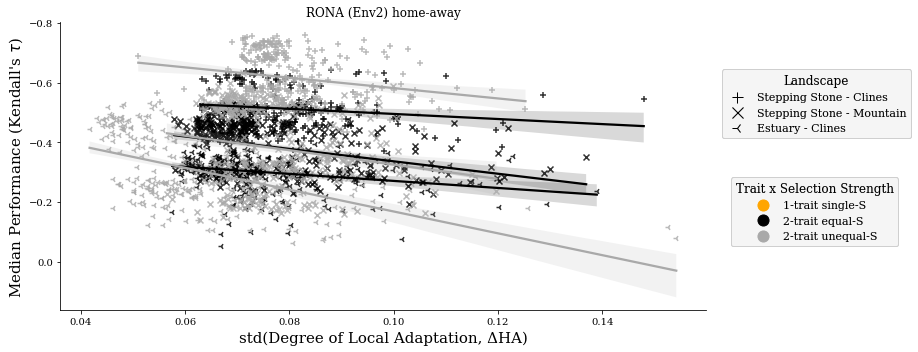

Saved to:  /work/lotterhos/MVP-Offsets/run_20220919/summaries/figs/00_estimate_var_LA/median_peformance_vs_std_la_home-away_RONA-temp_opt.pdf


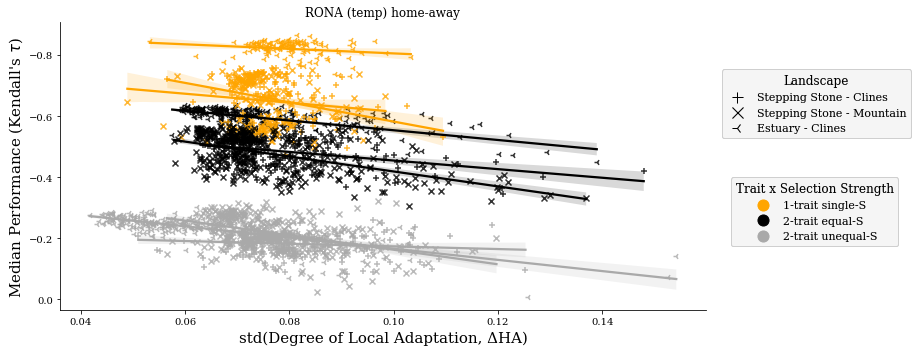

Saved to:  /work/lotterhos/MVP-Offsets/run_20220919/summaries/figs/00_estimate_var_LA/median_peformance_vs_std_la_home-away_lfmm2.pdf


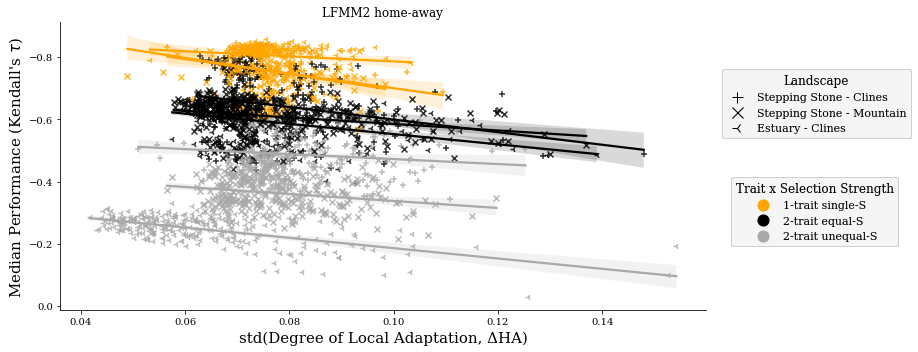

Saved to:  /work/lotterhos/MVP-Offsets/run_20220919/summaries/figs/00_estimate_var_LA/median_peformance_vs_std_la_home-away_rda-nocorr.pdf


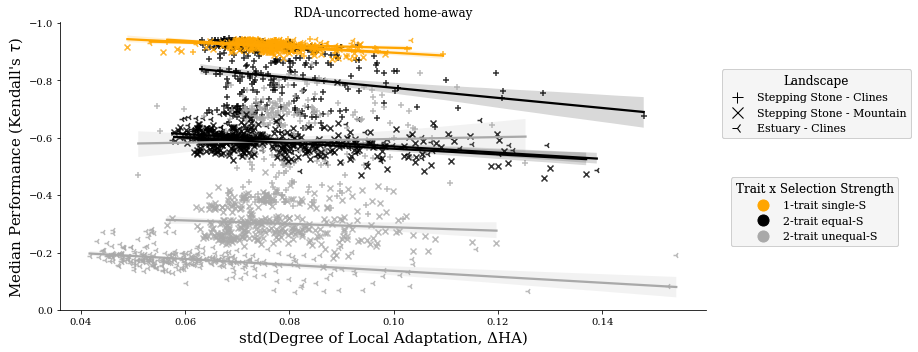

Saved to:  /work/lotterhos/MVP-Offsets/run_20220919/summaries/figs/00_estimate_var_LA/median_peformance_vs_std_la_home-away_rda-structcorr.pdf


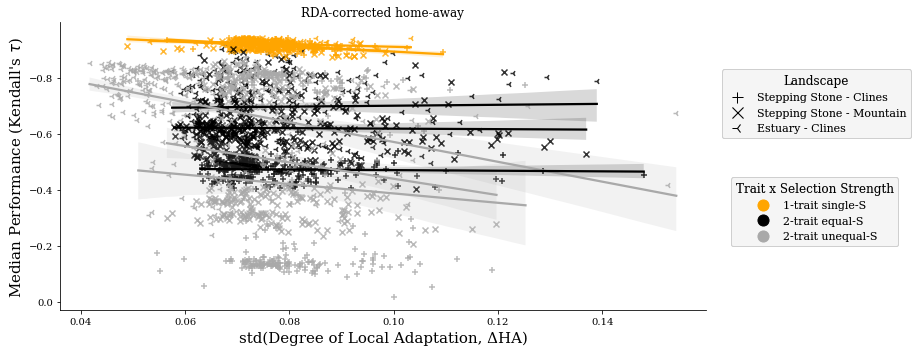

Saved to:  /work/lotterhos/MVP-Offsets/run_20220919/summaries/figs/00_estimate_var_LA/median_peformance_vs_std_la_home-away_GF.pdf


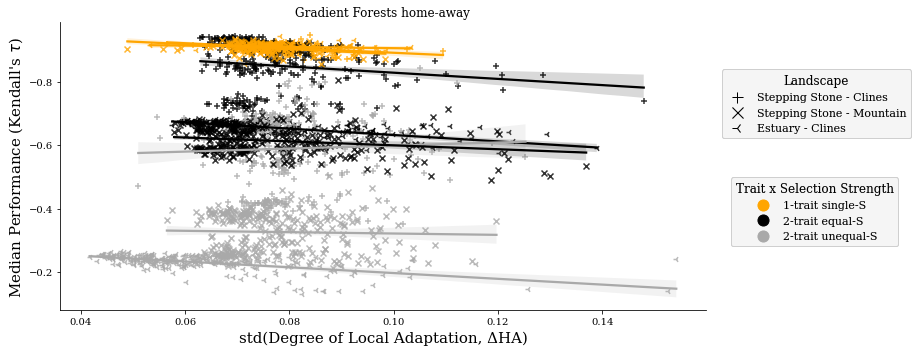

Saved to:  /work/lotterhos/MVP-Offsets/run_20220919/summaries/figs/00_estimate_var_LA/median_peformance_vs_std_la_local-foreign_RONA-sal_opt.pdf


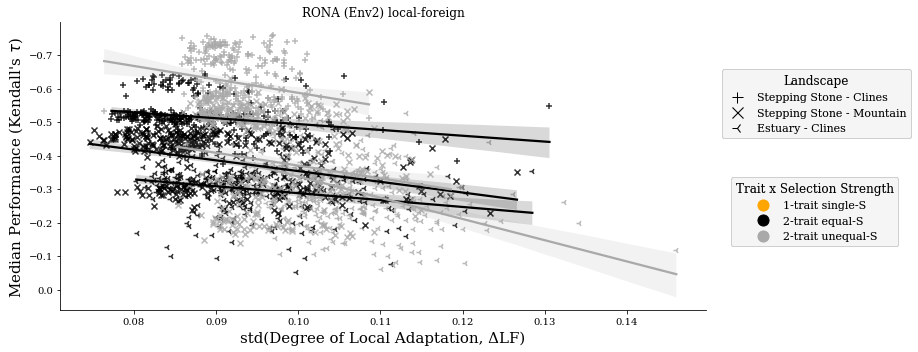

Saved to:  /work/lotterhos/MVP-Offsets/run_20220919/summaries/figs/00_estimate_var_LA/median_peformance_vs_std_la_local-foreign_RONA-temp_opt.pdf


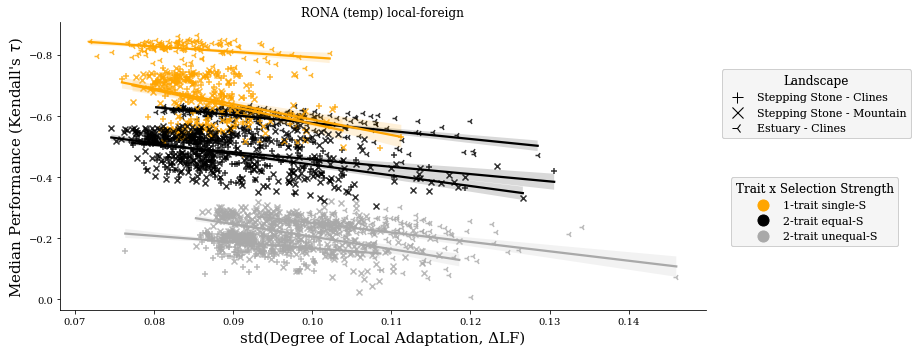

Saved to:  /work/lotterhos/MVP-Offsets/run_20220919/summaries/figs/00_estimate_var_LA/median_peformance_vs_std_la_local-foreign_lfmm2.pdf


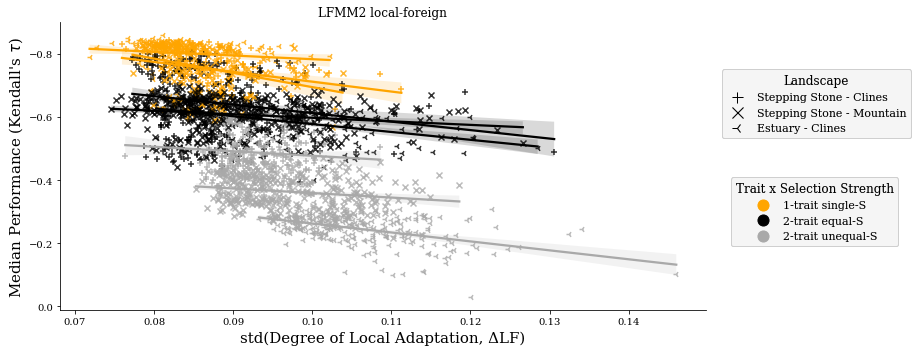

Saved to:  /work/lotterhos/MVP-Offsets/run_20220919/summaries/figs/00_estimate_var_LA/median_peformance_vs_std_la_local-foreign_rda-nocorr.pdf


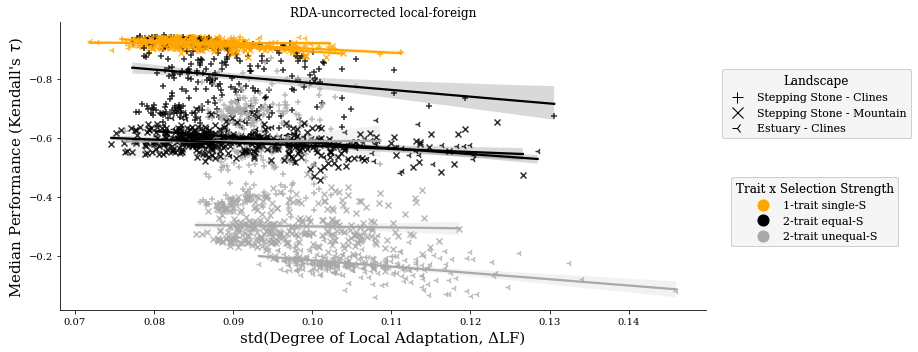

Saved to:  /work/lotterhos/MVP-Offsets/run_20220919/summaries/figs/00_estimate_var_LA/median_peformance_vs_std_la_local-foreign_rda-structcorr.pdf


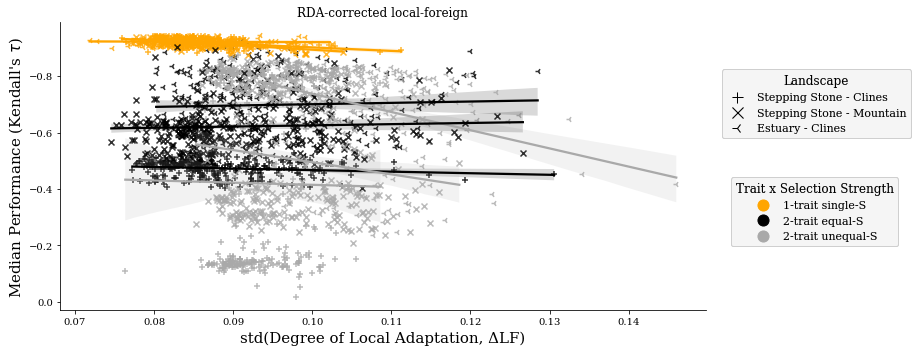

Saved to:  /work/lotterhos/MVP-Offsets/run_20220919/summaries/figs/00_estimate_var_LA/median_peformance_vs_std_la_local-foreign_GF.pdf


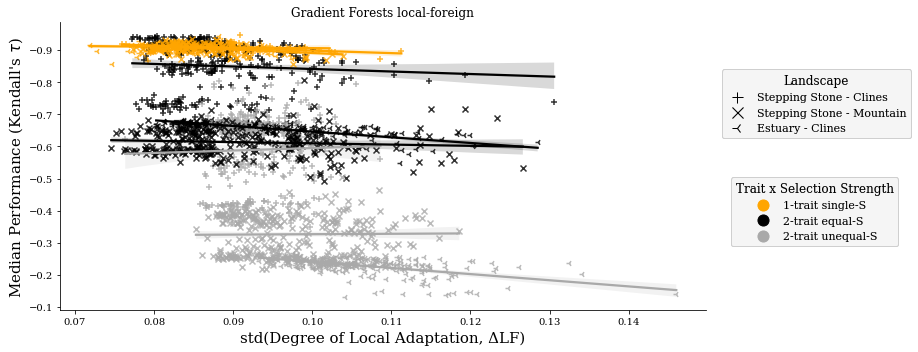

In [40]:
# separate slevels by program
for la_type in ['home-away', 'local-foreign']:
    for program in mvp.hue_order['program']:
        data = all_data[all_data.program == program]
        levels = sorted(data['landscape-slevel'].unique())
        
        g = sns.lmplot(
            data=data,
            x=f'std({la_type})',
            y='score',
            hue='landscape-slevel',
            hue_order=levels,
            palette=mvp.boxplot_kwargs['palette'],
            markers=pd.Series(levels).map(mvp.markers).tolist(),
            legend=False
        )

        g.figure.set_size_inches(10, 5)

        g.ax.invert_yaxis()

    #     mvp.add_legend(g.figure, color_by='landscape-slevel')

        g.ax.set_ylabel("Median Performance (Kendall's $\\tau$)", fontsize=15)

        g.ax.set_xlabel(f"std(Degree of Local Adaptation, {la_name[la_type]})", fontsize=15)

        g.set(title=f'{mvp.factor_names[program]} {la_type}')

        mvp.add_legend(g.figure, color_by='landscape', use_markers=True, markeredgecolor='k',
                       loc='center left', bbox_to_anchor=(1, 0.7))

        mvp.add_legend(g.figure, color_by='slevel_plus1', loc='center left', bbox_to_anchor=(1.013, 0.4))

        g.tight_layout()

        save_pdf(f'{figdir}/median_peformance_vs_std_la_{la_type}_{program}.pdf')

        plt.show()

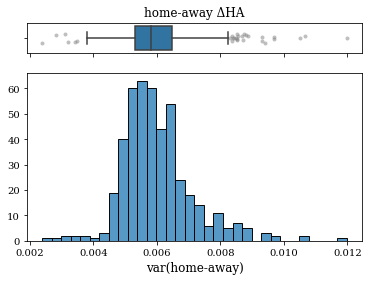

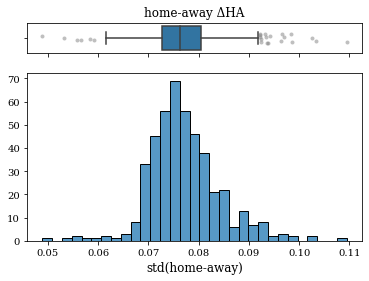

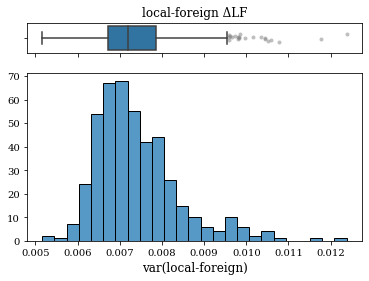

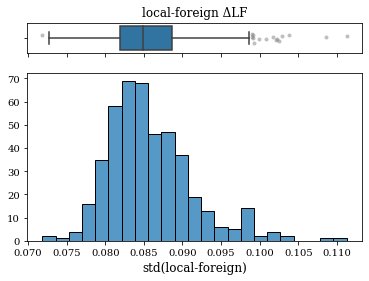

In [41]:
for la_type in ['home-away', 'local-foreign']:
    for measure in ['var', 'std']:
        ax_hist, ax_box = histo_box(
            params[params.plevel == '1-trait'][f'{measure}({la_type})'],
            xlab=f'{measure}({la_type})',
            title=f'{la_type} {la_name[la_type]}'
        )

In [42]:
formatclock(dt.now() - t0)

'0-00:02:39'